# Бейзлайн для распознавания автомобильных номеров. 

MADE with love :)

In [1]:
import os
import gc
import json
import glob
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import tqdm

import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

import PIL
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

In [2]:
torch.__version__, torch.cuda.is_available()

('1.4.0', True)

In [3]:
THRESHOLD_SCORE = 0.93
TRESHOLD_MASK = 0.05

### Сейчас будет много вспомогательных функций, которые можно промотать

Чтобы было наглядно и не приходилось лезть в модули, чтобы посмотреть, какая функция что делает, оставил для наглядности пока что все в ноутбуке. Можно аккуратно перенести в модули :)

In [4]:
# Бинарный поиск для приближения предсказанной маски 4-хугольником
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

# Отображаем 4-хугольник в прямоугольник 
# Спасибо ulebok за идею 
# И вот этим ребятам за реализацию: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


# Визуализируем детекцию (4 точки, bounding box и приближенный по маске контур)
def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None, save=False):
    img = cv2.imread(file)
    img_tensor = my_transforms(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    base, ext = os.path.splitext(os.path.basename(file))
        
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:,:] = (0, 0, 0)
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]
        
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max]
            
            if save:
                path = os.path.join(CUR_PATH, 'processed', base + '.bbox' + str(i) + ext)
                cv2.imwrite(path, crop_img)
            else:
                print('Bounding box:')
                show_image(crop_img, figsize=(10, 2))
            
            # В разных версиях opencv этот метод возвращает разное число параметров
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            #_,contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
#                 points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            if save:
                path = os.path.join(CUR_PATH, 'processed', base + '.poly' + str(i) + ext)
                cv2.imwrite(path, crop_mask_img)
            else:
                print('Rotated img:')
                show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
    if save:
        path = os.path.join(CUR_PATH, 'processed', base + ext)
        cv2.imwrite(path, image)  
    else:        
        show_image(image)
    return prediction

# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    

# Переводит предсказания модели в текст. С семинара
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out
    

        
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
# Чтобы без проблем сериализовывать json. Без него есть нюансы
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

In [5]:
DATA_PATH = '/home/mikhailo/dev/python/made/cv-2020/hw/hw2/data/'
CUR_PATH = '/home/mikhailo/dev/python/made/cv-2020/hw/hw2/bl2/'
OCR_PATH = '/home/mikhailo/dev/python/made/cv-2020/hw/hw2/bl2/plates_all'
TRAIN_SIZE = 0.99
BATCH_SIZE = 2
BATCH_SIZE_OCR = 16
DETECTOR_MODEL_PATH = 'detector.pt'
OCR_MODEL_PATH = 'ocr.pt'

all_marks = load_json(os.path.join(DATA_PATH, 'train.json'))
test_start = int(TRAIN_SIZE * len(all_marks))
train_marks = all_marks[:test_start]
val_marks = all_marks[test_start:]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 1. Находим номера

### a) Модель для детекции

В задании есть данные о 4 точках, которые задают номер. Эти 4 точки - почти всегда не прямоугольник, а произвольный четырехугольник. Будем предсказывать:

- bounding box, который окружает точки (детекция)
- маску, заполненную тем, что внутри 4-х точек (сегментация)

Поэтому, возьмем maskrcnn. Будем обучать несколько последних солев. Этого с запасом хватает.

In [6]:
def get_detector_model():
    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        pretrained_backbone=True,
        progress=True, 
        num_classes=91, 
    )

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor = box_predictor
    
    mask_predictor = MaskRCNNPredictor(256, 256, num_classes)
    model.roi_heads.mask_predictor = mask_predictor

    # Заморозим все слои кроме последних
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    return model

### b) Датасет для детекции

In [7]:
class DetectionDataset(Dataset):
    def __init__(self, marks, img_folder, transforms=None):
        
        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{self.img_folder}{item["file"]}'
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        
        box_coords = item['nums']
        boxes = []
        labels = []
        masks = []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)
            
            # Здесь мы наши 4 точки превращаем в маску
            # Это нужно, чтобы кроме bounding box предсказывать и, соответственно, маску :)
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
            
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    
    def __len__(self):
        return len(self.marks)
    
my_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder=DATA_PATH, 
    transforms=my_transforms
)
val_dataset = DetectionDataset(
    marks=val_marks, 
    img_folder=DATA_PATH, 
    transforms=my_transforms
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=4,
    collate_fn=collate_fn, 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=4,
    collate_fn=collate_fn, 
)

### c) Обучаем модель для детекции

In [8]:
torch.cuda.empty_cache()
gc.collect()
model = get_detector_model()
# model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
model.to(device);

Валидироваться на чем-то нет смысла, ибо лосс перестает падать еще до того момента, как пройдет 1-я эпоха. Т.е. лосс на трейне вполне валидный, ибо модель видит данные в первый раз.

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

In [9]:


model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 

  0%|          | 20/12688 [00:07<1:16:41,  2.75it/s]

Loss: 0.9150747


  0%|          | 40/12688 [00:14<1:15:17,  2.80it/s]

Loss: 0.4406008


  0%|          | 60/12688 [00:22<1:19:31,  2.65it/s]

Loss: 0.3493972


  1%|          | 80/12688 [00:29<1:12:11,  2.91it/s]

Loss: 0.2991011


  1%|          | 100/12688 [00:35<1:10:40,  2.97it/s]

Loss: 0.2845255


  1%|          | 120/12688 [00:42<1:12:36,  2.88it/s]

Loss: 0.2331471


  1%|          | 140/12688 [00:49<1:10:10,  2.98it/s]

Loss: 0.2416766


  1%|▏         | 160/12688 [00:56<1:09:29,  3.01it/s]

Loss: 0.2128584


  1%|▏         | 180/12688 [01:02<1:13:26,  2.84it/s]

Loss: 0.2384523


  2%|▏         | 200/12688 [01:09<1:09:15,  3.00it/s]

Loss: 0.2392708


  2%|▏         | 220/12688 [01:16<1:09:11,  3.00it/s]

Loss: 0.1749094


  2%|▏         | 240/12688 [01:23<1:11:33,  2.90it/s]

Loss: 0.1948326


  2%|▏         | 260/12688 [01:30<1:11:23,  2.90it/s]

Loss: 0.2090541


  2%|▏         | 280/12688 [01:36<1:07:05,  3.08it/s]

Loss: 0.2027883


  2%|▏         | 300/12688 [01:43<1:09:34,  2.97it/s]

Loss: 0.1822179


  3%|▎         | 320/12688 [01:50<1:08:34,  3.01it/s]

Loss: 0.1931971


  3%|▎         | 340/12688 [01:57<1:11:57,  2.86it/s]

Loss: 0.2154997


  3%|▎         | 360/12688 [02:04<1:11:27,  2.88it/s]

Loss: 0.1903484


  3%|▎         | 380/12688 [02:11<1:08:11,  3.01it/s]

Loss: 0.1863657


  3%|▎         | 400/12688 [02:18<1:09:41,  2.94it/s]

Loss: 0.1773634


  3%|▎         | 420/12688 [02:24<1:09:57,  2.92it/s]

Loss: 0.1980805


  3%|▎         | 440/12688 [02:31<1:09:06,  2.95it/s]

Loss: 0.1947367


  4%|▎         | 460/12688 [02:38<1:12:35,  2.81it/s]

Loss: 0.1794277


  4%|▍         | 480/12688 [02:45<1:09:20,  2.93it/s]

Loss: 0.2323529


  4%|▍         | 500/12688 [02:52<1:07:56,  2.99it/s]

Loss: 0.1880989


  4%|▍         | 520/12688 [02:59<1:07:15,  3.02it/s]

Loss: 0.2042047


  4%|▍         | 540/12688 [03:06<1:10:08,  2.89it/s]

Loss: 0.2008372


  4%|▍         | 560/12688 [03:12<1:06:39,  3.03it/s]

Loss: 0.2047435


  5%|▍         | 580/12688 [03:19<1:07:35,  2.99it/s]

Loss: 0.2268257


  5%|▍         | 600/12688 [03:26<1:09:59,  2.88it/s]

Loss: 0.1877936


  5%|▍         | 620/12688 [03:33<1:08:16,  2.95it/s]

Loss: 0.1955531


  5%|▌         | 640/12688 [03:40<1:08:45,  2.92it/s]

Loss: 0.1995484
Epoch    32: reducing learning rate of group 0 to 1.5000e-04.


  5%|▌         | 660/12688 [03:47<1:11:15,  2.81it/s]

Loss: 0.1743428


  5%|▌         | 680/12688 [03:53<1:05:01,  3.08it/s]

Loss: 0.1765139


  6%|▌         | 700/12688 [04:00<1:05:25,  3.05it/s]

Loss: 0.1688397


  6%|▌         | 720/12688 [04:07<1:09:51,  2.86it/s]

Loss: 0.1430467


  6%|▌         | 740/12688 [04:14<1:08:01,  2.93it/s]

Loss: 0.1715726


  6%|▌         | 760/12688 [04:21<1:11:02,  2.80it/s]

Loss: 0.1859798


  6%|▌         | 780/12688 [04:28<1:05:37,  3.02it/s]

Loss: 0.1717166


  6%|▋         | 800/12688 [04:35<1:10:35,  2.81it/s]

Loss: 0.1861521


  6%|▋         | 820/12688 [04:42<1:07:32,  2.93it/s]

Loss: 0.1931960


  7%|▋         | 840/12688 [04:49<1:05:00,  3.04it/s]

Loss: 0.1825451


  7%|▋         | 860/12688 [04:55<1:05:39,  3.00it/s]

Loss: 0.1639939


  7%|▋         | 880/12688 [05:03<1:06:26,  2.96it/s]

Loss: 0.1833854


  7%|▋         | 900/12688 [05:09<1:04:22,  3.05it/s]

Loss: 0.1453078


  7%|▋         | 920/12688 [05:16<1:06:47,  2.94it/s]

Loss: 0.1752573


  7%|▋         | 940/12688 [05:23<1:07:09,  2.92it/s]

Loss: 0.1733359


  8%|▊         | 960/12688 [05:30<1:10:51,  2.76it/s]

Loss: 0.1960207


  8%|▊         | 980/12688 [05:37<1:04:38,  3.02it/s]

Loss: 0.1740392


  8%|▊         | 1000/12688 [05:44<1:10:58,  2.74it/s]

Loss: 0.1538064


  8%|▊         | 1020/12688 [05:51<1:07:04,  2.90it/s]

Loss: 0.1775671


  8%|▊         | 1040/12688 [05:59<1:07:59,  2.85it/s]

Loss: 0.1870302


  8%|▊         | 1060/12688 [06:06<1:04:17,  3.01it/s]

Loss: 0.1731373


  9%|▊         | 1080/12688 [06:13<1:05:53,  2.94it/s]

Loss: 0.1726406


  9%|▊         | 1100/12688 [06:20<1:04:56,  2.97it/s]

Loss: 0.1583038


  9%|▉         | 1120/12688 [06:27<1:03:30,  3.04it/s]

Loss: 0.1678053


  9%|▉         | 1140/12688 [06:34<1:05:47,  2.93it/s]

Loss: 0.1677352
Epoch    57: reducing learning rate of group 0 to 7.5000e-05.


  9%|▉         | 1160/12688 [06:40<1:05:37,  2.93it/s]

Loss: 0.1623326


  9%|▉         | 1180/12688 [06:47<1:07:38,  2.84it/s]

Loss: 0.1711001


  9%|▉         | 1200/12688 [06:54<1:09:32,  2.75it/s]

Loss: 0.1797962


 10%|▉         | 1220/12688 [07:01<1:08:42,  2.78it/s]

Loss: 0.1855254


 10%|▉         | 1240/12688 [07:08<1:04:24,  2.96it/s]

Loss: 0.1694958


 10%|▉         | 1260/12688 [07:15<1:06:02,  2.88it/s]

Loss: 0.1585745


 10%|█         | 1280/12688 [07:22<1:09:23,  2.74it/s]

Loss: 0.1612408


 10%|█         | 1300/12688 [07:29<1:03:13,  3.00it/s]

Loss: 0.1637593


 10%|█         | 1320/12688 [07:36<1:06:07,  2.87it/s]

Loss: 0.1653933


 11%|█         | 1340/12688 [07:43<1:05:00,  2.91it/s]

Loss: 0.1659580


 11%|█         | 1360/12688 [07:50<1:06:16,  2.85it/s]

Loss: 0.1795121


 11%|█         | 1380/12688 [07:57<1:03:36,  2.96it/s]

Loss: 0.1662375


 11%|█         | 1400/12688 [08:04<1:03:47,  2.95it/s]

Loss: 0.1580821


 11%|█         | 1420/12688 [08:10<1:03:34,  2.95it/s]

Loss: 0.1803712


 11%|█▏        | 1440/12688 [08:17<1:08:04,  2.75it/s]

Loss: 0.1791125


 12%|█▏        | 1460/12688 [08:24<1:05:06,  2.87it/s]

Loss: 0.1844415


 12%|█▏        | 1480/12688 [08:31<1:04:15,  2.91it/s]

Loss: 0.1668306


 12%|█▏        | 1500/12688 [08:38<1:02:43,  2.97it/s]

Loss: 0.1737564


 12%|█▏        | 1520/12688 [08:45<1:05:36,  2.84it/s]

Loss: 0.1372031


 12%|█▏        | 1540/12688 [08:52<1:11:13,  2.61it/s]

Loss: 0.1721813


 12%|█▏        | 1560/12688 [08:59<1:04:01,  2.90it/s]

Loss: 0.1976432


 12%|█▏        | 1580/12688 [09:06<1:02:40,  2.95it/s]

Loss: 0.1604838


 13%|█▎        | 1600/12688 [09:13<1:06:04,  2.80it/s]

Loss: 0.1700250


 13%|█▎        | 1620/12688 [09:20<1:02:38,  2.94it/s]

Loss: 0.1505236


 13%|█▎        | 1640/12688 [09:26<1:03:09,  2.92it/s]

Loss: 0.1655240


 13%|█▎        | 1660/12688 [09:34<1:02:21,  2.95it/s]

Loss: 0.1765759


 13%|█▎        | 1680/12688 [09:40<1:03:25,  2.89it/s]

Loss: 0.1632641


 13%|█▎        | 1700/12688 [09:48<1:09:53,  2.62it/s]

Loss: 0.2088216


 14%|█▎        | 1720/12688 [09:55<1:06:09,  2.76it/s]

Loss: 0.1663984


 14%|█▎        | 1740/12688 [10:01<1:01:54,  2.95it/s]

Loss: 0.1955830


 14%|█▍        | 1760/12688 [10:09<1:04:58,  2.80it/s]

Loss: 0.1921270


 14%|█▍        | 1780/12688 [10:16<1:05:20,  2.78it/s]

Loss: 0.1696436


 14%|█▍        | 1800/12688 [10:22<1:00:24,  3.00it/s]

Loss: 0.1408385


 14%|█▍        | 1820/12688 [10:29<1:05:24,  2.77it/s]

Loss: 0.1708475


 15%|█▍        | 1840/12688 [10:36<1:04:52,  2.79it/s]

Loss: 0.1502524


 15%|█▍        | 1860/12688 [10:43<1:05:11,  2.77it/s]

Loss: 0.1743881


 15%|█▍        | 1880/12688 [10:50<1:03:54,  2.82it/s]

Loss: 0.1689167


 15%|█▍        | 1900/12688 [10:57<59:03,  3.04it/s]  

Loss: 0.1567316


 15%|█▌        | 1920/12688 [11:04<1:06:34,  2.70it/s]

Loss: 0.1987068


 15%|█▌        | 1940/12688 [11:11<1:00:49,  2.94it/s]

Loss: 0.1618642
Epoch    97: reducing learning rate of group 0 to 3.7500e-05.


 15%|█▌        | 1960/12688 [11:18<59:53,  2.99it/s]  

Loss: 0.1834898


 16%|█▌        | 1980/12688 [11:25<1:00:18,  2.96it/s]

Loss: 0.1591666


 16%|█▌        | 2000/12688 [11:32<58:28,  3.05it/s]  

Loss: 0.1557184


 16%|█▌        | 2020/12688 [11:38<58:46,  3.03it/s]  

Loss: 0.1512874


 16%|█▌        | 2040/12688 [11:45<59:28,  2.98it/s]  

Loss: 0.1358186


 16%|█▌        | 2060/12688 [11:52<1:00:23,  2.93it/s]

Loss: 0.1390326


 16%|█▋        | 2080/12688 [11:59<1:02:18,  2.84it/s]

Loss: 0.1770933


 17%|█▋        | 2100/12688 [12:06<1:01:41,  2.86it/s]

Loss: 0.1755902


 17%|█▋        | 2120/12688 [12:13<59:32,  2.96it/s]  

Loss: 0.1596063


 17%|█▋        | 2140/12688 [12:20<1:01:12,  2.87it/s]

Loss: 0.1763360


 17%|█▋        | 2160/12688 [12:27<1:05:28,  2.68it/s]

Loss: 0.1452265


 17%|█▋        | 2180/12688 [12:34<1:00:13,  2.91it/s]

Loss: 0.1575424


 17%|█▋        | 2200/12688 [12:41<1:04:07,  2.73it/s]

Loss: 0.1876241


 17%|█▋        | 2220/12688 [12:48<1:03:49,  2.73it/s]

Loss: 0.1553172


 18%|█▊        | 2240/12688 [12:55<1:04:22,  2.71it/s]

Loss: 0.1556505


 18%|█▊        | 2260/12688 [13:02<56:29,  3.08it/s]  

Loss: 0.1768560


 18%|█▊        | 2280/12688 [13:09<1:01:00,  2.84it/s]

Loss: 0.1833751


 18%|█▊        | 2300/12688 [13:16<1:01:19,  2.82it/s]

Loss: 0.1698299


 18%|█▊        | 2320/12688 [13:23<1:02:24,  2.77it/s]

Loss: 0.1540960


 18%|█▊        | 2340/12688 [13:31<1:02:48,  2.75it/s]

Loss: 0.1805691


 19%|█▊        | 2360/12688 [13:38<59:06,  2.91it/s]  

Loss: 0.1574241


 19%|█▉        | 2380/12688 [13:45<1:00:58,  2.82it/s]

Loss: 0.1581353


 19%|█▉        | 2400/12688 [13:52<57:57,  2.96it/s]  

Loss: 0.1599110


 19%|█▉        | 2420/12688 [13:59<1:02:49,  2.72it/s]

Loss: 0.1764532


 19%|█▉        | 2440/12688 [14:07<1:02:51,  2.72it/s]

Loss: 0.1580130


 19%|█▉        | 2460/12688 [14:14<1:03:35,  2.68it/s]

Loss: 0.1336896


 20%|█▉        | 2480/12688 [14:21<58:16,  2.92it/s]  

Loss: 0.1565332


 20%|█▉        | 2500/12688 [14:28<1:00:42,  2.80it/s]

Loss: 0.1308137


 20%|█▉        | 2520/12688 [14:36<1:02:06,  2.73it/s]

Loss: 0.1421469


 20%|██        | 2540/12688 [14:43<58:51,  2.87it/s]  

Loss: 0.1665350


 20%|██        | 2560/12688 [14:50<1:01:49,  2.73it/s]

Loss: 0.1629217


 20%|██        | 2580/12688 [14:57<58:01,  2.90it/s]  

Loss: 0.1669022


 20%|██        | 2600/12688 [15:04<59:06,  2.84it/s]  

Loss: 0.1796572


 21%|██        | 2620/12688 [15:11<56:50,  2.95it/s]

Loss: 0.1583801


 21%|██        | 2640/12688 [15:18<56:53,  2.94it/s]

Loss: 0.1476833


 21%|██        | 2660/12688 [15:24<56:33,  2.96it/s]  

Loss: 0.1548904


 21%|██        | 2680/12688 [15:32<56:03,  2.98it/s]  

Loss: 0.1572107


 21%|██▏       | 2700/12688 [15:39<57:35,  2.89it/s]

Loss: 0.1509854


 21%|██▏       | 2720/12688 [15:46<57:21,  2.90it/s]  

Loss: 0.1669435


 22%|██▏       | 2740/12688 [15:53<54:59,  3.02it/s]  

Loss: 0.1837973


 22%|██▏       | 2760/12688 [16:01<58:44,  2.82it/s]  

Loss: 0.1661492


 22%|██▏       | 2780/12688 [16:07<54:40,  3.02it/s]  

Loss: 0.1604757


 22%|██▏       | 2800/12688 [16:14<56:00,  2.94it/s]

Loss: 0.1549130


 22%|██▏       | 2820/12688 [16:21<54:05,  3.04it/s]  

Loss: 0.1535871


 22%|██▏       | 2840/12688 [16:28<57:43,  2.84it/s]  

Loss: 0.1521070


 23%|██▎       | 2860/12688 [16:35<56:24,  2.90it/s]

Loss: 0.1713263


 23%|██▎       | 2880/12688 [16:42<59:18,  2.76it/s]  

Loss: 0.1549117


 23%|██▎       | 2900/12688 [16:49<55:05,  2.96it/s]

Loss: 0.1700425


 23%|██▎       | 2920/12688 [16:56<56:46,  2.87it/s]

Loss: 0.1560279
Epoch   146: reducing learning rate of group 0 to 1.8750e-05.


 23%|██▎       | 2940/12688 [17:03<55:29,  2.93it/s]  

Loss: 0.1733220


 23%|██▎       | 2960/12688 [17:11<56:39,  2.86it/s]  

Loss: 0.1463272


 23%|██▎       | 2980/12688 [17:17<53:46,  3.01it/s]

Loss: 0.1417556


 24%|██▎       | 3000/12688 [17:25<58:15,  2.77it/s]  

Loss: 0.1389027


 24%|██▍       | 3020/12688 [17:31<56:15,  2.86it/s]  

Loss: 0.1742804


 24%|██▍       | 3040/12688 [17:39<59:59,  2.68it/s]  

Loss: 0.1582426


 24%|██▍       | 3060/12688 [17:46<53:22,  3.01it/s]

Loss: 0.1512305


 24%|██▍       | 3080/12688 [17:52<55:18,  2.90it/s]

Loss: 0.1423689


 24%|██▍       | 3100/12688 [17:59<53:43,  2.97it/s]

Loss: 0.1437603


 25%|██▍       | 3120/12688 [18:06<56:14,  2.84it/s]

Loss: 0.1641940


 25%|██▍       | 3140/12688 [18:13<54:00,  2.95it/s]

Loss: 0.1262987


 25%|██▍       | 3160/12688 [18:21<56:56,  2.79it/s]  

Loss: 0.1603362


 25%|██▌       | 3180/12688 [18:28<58:53,  2.69it/s]  

Loss: 0.1629721


 25%|██▌       | 3200/12688 [18:35<52:59,  2.98it/s]  

Loss: 0.1293353


 25%|██▌       | 3220/12688 [18:42<56:14,  2.81it/s]

Loss: 0.1298984


 26%|██▌       | 3240/12688 [18:49<53:53,  2.92it/s]

Loss: 0.1473736


 26%|██▌       | 3260/12688 [18:56<54:46,  2.87it/s]

Loss: 0.1493374


 26%|██▌       | 3280/12688 [19:03<53:17,  2.94it/s]

Loss: 0.1434489


 26%|██▌       | 3300/12688 [19:10<54:07,  2.89it/s]

Loss: 0.1569528


 26%|██▌       | 3320/12688 [19:17<55:49,  2.80it/s]

Loss: 0.1657048


 26%|██▋       | 3340/12688 [19:24<55:02,  2.83it/s]

Loss: 0.1588798


 26%|██▋       | 3360/12688 [19:31<53:25,  2.91it/s]

Loss: 0.1491195


 27%|██▋       | 3380/12688 [19:38<53:48,  2.88it/s]

Loss: 0.1502014


 27%|██▋       | 3400/12688 [19:45<52:11,  2.97it/s]

Loss: 0.1440263


 27%|██▋       | 3420/12688 [19:52<53:15,  2.90it/s]

Loss: 0.1452327


 27%|██▋       | 3440/12688 [19:59<52:11,  2.95it/s]

Loss: 0.1662249


 27%|██▋       | 3460/12688 [20:06<52:09,  2.95it/s]

Loss: 0.1525042


 27%|██▋       | 3480/12688 [20:13<54:49,  2.80it/s]

Loss: 0.1534911


 28%|██▊       | 3500/12688 [20:19<52:29,  2.92it/s]

Loss: 0.1599468


 28%|██▊       | 3520/12688 [20:26<50:07,  3.05it/s]

Loss: 0.1588187


 28%|██▊       | 3540/12688 [20:33<51:42,  2.95it/s]

Loss: 0.1428392


 28%|██▊       | 3560/12688 [20:40<50:46,  3.00it/s]

Loss: 0.1702207
Epoch   178: reducing learning rate of group 0 to 9.3750e-06.


 28%|██▊       | 3580/12688 [20:47<52:54,  2.87it/s]

Loss: 0.1322278


 28%|██▊       | 3600/12688 [20:54<53:40,  2.82it/s]

Loss: 0.1459456


 29%|██▊       | 3620/12688 [21:01<50:17,  3.00it/s]

Loss: 0.1488905


 29%|██▊       | 3640/12688 [21:08<53:09,  2.84it/s]

Loss: 0.1504467


 29%|██▉       | 3660/12688 [21:15<49:38,  3.03it/s]

Loss: 0.1532399


 29%|██▉       | 3680/12688 [21:22<50:31,  2.97it/s]

Loss: 0.1566463


 29%|██▉       | 3700/12688 [21:29<50:36,  2.96it/s]

Loss: 0.1577618


 29%|██▉       | 3720/12688 [21:36<50:21,  2.97it/s]

Loss: 0.1531790


 29%|██▉       | 3740/12688 [21:43<52:44,  2.83it/s]

Loss: 0.1467436


 30%|██▉       | 3760/12688 [21:50<49:51,  2.98it/s]

Loss: 0.1419106


 30%|██▉       | 3780/12688 [21:57<52:00,  2.85it/s]

Loss: 0.1609812


 30%|██▉       | 3800/12688 [22:03<51:06,  2.90it/s]

Loss: 0.1594129


 30%|███       | 3820/12688 [22:10<54:31,  2.71it/s]

Loss: 0.1319709


 30%|███       | 3840/12688 [22:17<49:04,  3.00it/s]

Loss: 0.1336611


 30%|███       | 3860/12688 [22:24<51:30,  2.86it/s]

Loss: 0.1377749


 31%|███       | 3880/12688 [22:31<48:01,  3.06it/s]

Loss: 0.1502371


 31%|███       | 3900/12688 [22:38<55:07,  2.66it/s]  

Loss: 0.1532082


 31%|███       | 3920/12688 [22:45<53:19,  2.74it/s]

Loss: 0.1404394


 31%|███       | 3940/12688 [22:52<48:34,  3.00it/s]

Loss: 0.1712868


 31%|███       | 3960/12688 [22:59<50:50,  2.86it/s]

Loss: 0.1956379


 31%|███▏      | 3980/12688 [23:06<47:07,  3.08it/s]

Loss: 0.1542117
Epoch   199: reducing learning rate of group 0 to 4.6875e-06.


 32%|███▏      | 4000/12688 [23:13<50:11,  2.88it/s]

Loss: 0.1637038


 32%|███▏      | 4020/12688 [23:20<49:56,  2.89it/s]

Loss: 0.1536010


 32%|███▏      | 4040/12688 [23:27<47:46,  3.02it/s]

Loss: 0.1780287


 32%|███▏      | 4060/12688 [23:34<50:44,  2.83it/s]

Loss: 0.1489287


 32%|███▏      | 4080/12688 [23:41<51:15,  2.80it/s]

Loss: 0.1534370


 32%|███▏      | 4100/12688 [23:48<46:55,  3.05it/s]

Loss: 0.1263743


 32%|███▏      | 4120/12688 [23:54<47:08,  3.03it/s]

Loss: 0.1456664


 33%|███▎      | 4140/12688 [24:01<51:09,  2.79it/s]

Loss: 0.1601861


 33%|███▎      | 4160/12688 [24:08<49:56,  2.85it/s]

Loss: 0.1728708


 33%|███▎      | 4180/12688 [24:15<50:48,  2.79it/s]

Loss: 0.1296414


 33%|███▎      | 4200/12688 [24:22<52:20,  2.70it/s]

Loss: 0.1433011


 33%|███▎      | 4220/12688 [24:29<48:20,  2.92it/s]

Loss: 0.1444721


 33%|███▎      | 4240/12688 [24:36<49:20,  2.85it/s]

Loss: 0.1302033


 34%|███▎      | 4260/12688 [24:43<50:36,  2.78it/s]

Loss: 0.1287558


 34%|███▎      | 4280/12688 [24:50<50:32,  2.77it/s]

Loss: 0.1619225


 34%|███▍      | 4300/12688 [24:57<49:35,  2.82it/s]

Loss: 0.1459282


 34%|███▍      | 4320/12688 [25:04<47:16,  2.95it/s]

Loss: 0.1748968


 34%|███▍      | 4340/12688 [25:11<49:22,  2.82it/s]

Loss: 0.1481064


 34%|███▍      | 4360/12688 [25:19<50:12,  2.76it/s]  

Loss: 0.1435162


 35%|███▍      | 4380/12688 [25:26<45:23,  3.05it/s]

Loss: 0.1564532


 35%|███▍      | 4400/12688 [25:33<48:07,  2.87it/s]

Loss: 0.1514025
Epoch   220: reducing learning rate of group 0 to 2.3437e-06.


 35%|███▍      | 4420/12688 [25:40<45:01,  3.06it/s]

Loss: 0.1682111


 35%|███▍      | 4440/12688 [25:47<48:58,  2.81it/s]

Loss: 0.1667649


 35%|███▌      | 4460/12688 [25:54<49:36,  2.76it/s]

Loss: 0.1383338


 35%|███▌      | 4480/12688 [26:01<48:25,  2.83it/s]

Loss: 0.1610080


 35%|███▌      | 4500/12688 [26:08<47:41,  2.86it/s]

Loss: 0.1482335


 36%|███▌      | 4520/12688 [26:14<45:26,  3.00it/s]

Loss: 0.1475608


 36%|███▌      | 4540/12688 [26:21<46:04,  2.95it/s]

Loss: 0.1672018


 36%|███▌      | 4560/12688 [26:28<48:42,  2.78it/s]

Loss: 0.1623737


 36%|███▌      | 4580/12688 [26:35<46:03,  2.93it/s]

Loss: 0.1694769


 36%|███▋      | 4600/12688 [26:42<45:16,  2.98it/s]

Loss: 0.1441865


 36%|███▋      | 4620/12688 [26:49<45:57,  2.93it/s]

Loss: 0.1556969


 37%|███▋      | 4640/12688 [26:56<51:51,  2.59it/s]

Loss: 0.1739515


 37%|███▋      | 4660/12688 [27:03<45:17,  2.95it/s]

Loss: 0.1570210


 37%|███▋      | 4680/12688 [27:10<45:21,  2.94it/s]

Loss: 0.1379224


 37%|███▋      | 4700/12688 [27:17<46:14,  2.88it/s]

Loss: 0.1329408


 37%|███▋      | 4720/12688 [27:24<46:09,  2.88it/s]

Loss: 0.1553969


 37%|███▋      | 4740/12688 [27:31<47:34,  2.78it/s]

Loss: 0.1673220


 38%|███▊      | 4760/12688 [27:38<46:23,  2.85it/s]

Loss: 0.1437905


 38%|███▊      | 4780/12688 [27:45<44:46,  2.94it/s]

Loss: 0.1504862


 38%|███▊      | 4800/12688 [27:52<45:32,  2.89it/s]

Loss: 0.1572356


 38%|███▊      | 4820/12688 [27:59<44:35,  2.94it/s]

Loss: 0.1610685
Epoch   241: reducing learning rate of group 0 to 1.1719e-06.


 38%|███▊      | 4840/12688 [28:06<45:19,  2.89it/s]

Loss: 0.1406784


 38%|███▊      | 4860/12688 [28:13<44:54,  2.90it/s]

Loss: 0.1421793


 38%|███▊      | 4880/12688 [28:19<44:00,  2.96it/s]

Loss: 0.1514178


 39%|███▊      | 4900/12688 [28:27<43:42,  2.97it/s]

Loss: 0.1510121


 39%|███▉      | 4920/12688 [28:33<45:21,  2.85it/s]

Loss: 0.1485021


 39%|███▉      | 4940/12688 [28:40<43:42,  2.95it/s]

Loss: 0.1620080


 39%|███▉      | 4960/12688 [28:47<47:22,  2.72it/s]

Loss: 0.1684194


 39%|███▉      | 4980/12688 [28:54<44:49,  2.87it/s]

Loss: 0.1839633


 39%|███▉      | 5000/12688 [29:01<42:56,  2.98it/s]

Loss: 0.1702471


 40%|███▉      | 5020/12688 [29:08<42:16,  3.02it/s]

Loss: 0.1370445


 40%|███▉      | 5040/12688 [29:15<45:41,  2.79it/s]

Loss: 0.1440390


 40%|███▉      | 5060/12688 [29:22<44:19,  2.87it/s]

Loss: 0.1517858


 40%|████      | 5080/12688 [29:29<43:04,  2.94it/s]

Loss: 0.1452680


 40%|████      | 5100/12688 [29:37<51:19,  2.46it/s]

Loss: 0.1377119


 40%|████      | 5120/12688 [29:44<46:47,  2.70it/s]

Loss: 0.1429014


 41%|████      | 5140/12688 [29:50<42:10,  2.98it/s]

Loss: 0.1749539


 41%|████      | 5160/12688 [29:57<43:57,  2.85it/s]

Loss: 0.1949553


 41%|████      | 5180/12688 [30:04<43:42,  2.86it/s]

Loss: 0.1519943


 41%|████      | 5200/12688 [30:11<42:30,  2.94it/s]

Loss: 0.1413547


 41%|████      | 5220/12688 [30:18<43:42,  2.85it/s]

Loss: 0.1405109


 41%|████▏     | 5240/12688 [30:26<44:38,  2.78it/s]

Loss: 0.1718380
Epoch   262: reducing learning rate of group 0 to 5.8594e-07.


 41%|████▏     | 5260/12688 [30:33<42:34,  2.91it/s]

Loss: 0.1605528


 42%|████▏     | 5280/12688 [30:40<42:14,  2.92it/s]

Loss: 0.1530268


 42%|████▏     | 5300/12688 [30:47<41:55,  2.94it/s]

Loss: 0.1674907


 42%|████▏     | 5320/12688 [30:54<42:01,  2.92it/s]

Loss: 0.1717612


 42%|████▏     | 5340/12688 [31:01<40:55,  2.99it/s]

Loss: 0.1463194


 42%|████▏     | 5360/12688 [31:08<43:19,  2.82it/s]

Loss: 0.1634795


 42%|████▏     | 5380/12688 [31:14<42:50,  2.84it/s]

Loss: 0.1468673


 43%|████▎     | 5400/12688 [31:21<42:07,  2.88it/s]

Loss: 0.1304836


 43%|████▎     | 5420/12688 [31:28<42:01,  2.88it/s]

Loss: 0.1564941


 43%|████▎     | 5440/12688 [31:35<41:25,  2.92it/s]

Loss: 0.1572570


 43%|████▎     | 5460/12688 [31:42<41:13,  2.92it/s]

Loss: 0.1563001


 43%|████▎     | 5480/12688 [31:49<40:53,  2.94it/s]

Loss: 0.1696142


 43%|████▎     | 5500/12688 [31:56<40:56,  2.93it/s]

Loss: 0.1463517


 44%|████▎     | 5520/12688 [32:03<40:47,  2.93it/s]

Loss: 0.1586905


 44%|████▎     | 5540/12688 [32:09<40:45,  2.92it/s]

Loss: 0.1521914


 44%|████▍     | 5560/12688 [32:16<40:15,  2.95it/s]

Loss: 0.1404511


 44%|████▍     | 5580/12688 [32:23<40:29,  2.93it/s]

Loss: 0.1616565


 44%|████▍     | 5600/12688 [32:31<41:05,  2.87it/s]

Loss: 0.1677861


 44%|████▍     | 5620/12688 [32:38<42:11,  2.79it/s]

Loss: 0.1550762


 44%|████▍     | 5640/12688 [32:45<39:38,  2.96it/s]

Loss: 0.1460621


 45%|████▍     | 5660/12688 [32:52<40:10,  2.92it/s]

Loss: 0.1827896
Epoch   283: reducing learning rate of group 0 to 2.9297e-07.


 45%|████▍     | 5680/12688 [32:59<41:05,  2.84it/s]

Loss: 0.1521557


 45%|████▍     | 5700/12688 [33:06<40:21,  2.89it/s]

Loss: 0.1360742


 45%|████▌     | 5720/12688 [33:13<38:48,  2.99it/s]

Loss: 0.1350859


 45%|████▌     | 5740/12688 [33:19<38:26,  3.01it/s]

Loss: 0.1432498


 45%|████▌     | 5760/12688 [33:26<39:08,  2.95it/s]

Loss: 0.1430654


 46%|████▌     | 5780/12688 [33:33<41:38,  2.76it/s]

Loss: 0.1755437


 46%|████▌     | 5800/12688 [33:40<39:04,  2.94it/s]

Loss: 0.1386253


 46%|████▌     | 5820/12688 [33:47<40:29,  2.83it/s]

Loss: 0.1407602


 46%|████▌     | 5840/12688 [33:54<40:01,  2.85it/s]

Loss: 0.1531007


 46%|████▌     | 5860/12688 [34:01<40:19,  2.82it/s]

Loss: 0.1443806


 46%|████▋     | 5880/12688 [34:08<40:48,  2.78it/s]

Loss: 0.1647673


 47%|████▋     | 5900/12688 [34:15<39:28,  2.87it/s]

Loss: 0.1278755


 47%|████▋     | 5920/12688 [34:23<38:32,  2.93it/s]

Loss: 0.1859764


 47%|████▋     | 5940/12688 [34:29<37:46,  2.98it/s]

Loss: 0.1503537


 47%|████▋     | 5960/12688 [34:37<41:56,  2.67it/s]

Loss: 0.1609535


 47%|████▋     | 5980/12688 [34:44<38:06,  2.93it/s]

Loss: 0.1501587


 47%|████▋     | 6000/12688 [34:50<38:28,  2.90it/s]

Loss: 0.1341505


 47%|████▋     | 6020/12688 [34:57<37:25,  2.97it/s]

Loss: 0.1418531


 48%|████▊     | 6040/12688 [35:04<40:00,  2.77it/s]

Loss: 0.1492904


 48%|████▊     | 6060/12688 [35:11<41:57,  2.63it/s]

Loss: 0.1521511


 48%|████▊     | 6080/12688 [35:18<38:33,  2.86it/s]

Loss: 0.1512238
Epoch   304: reducing learning rate of group 0 to 1.4648e-07.


 48%|████▊     | 6100/12688 [35:26<42:08,  2.61it/s]

Loss: 0.1300494


 48%|████▊     | 6120/12688 [35:33<40:53,  2.68it/s]

Loss: 0.1478502


 48%|████▊     | 6140/12688 [35:40<39:22,  2.77it/s]

Loss: 0.1547157


 49%|████▊     | 6160/12688 [35:48<37:51,  2.87it/s]

Loss: 0.1529529


 49%|████▊     | 6180/12688 [35:55<40:42,  2.66it/s]

Loss: 0.1464903


 49%|████▉     | 6200/12688 [36:02<38:11,  2.83it/s]

Loss: 0.1584587


 49%|████▉     | 6220/12688 [36:09<35:53,  3.00it/s]

Loss: 0.1527060


 49%|████▉     | 6240/12688 [36:16<40:39,  2.64it/s]

Loss: 0.1438779


 49%|████▉     | 6260/12688 [36:23<37:33,  2.85it/s]

Loss: 0.1348833


 49%|████▉     | 6280/12688 [36:30<39:18,  2.72it/s]

Loss: 0.1498584


 50%|████▉     | 6300/12688 [36:37<37:19,  2.85it/s]

Loss: 0.1554635


 50%|████▉     | 6320/12688 [36:44<35:45,  2.97it/s]

Loss: 0.1510442


 50%|████▉     | 6340/12688 [36:51<37:48,  2.80it/s]

Loss: 0.1675637


 50%|█████     | 6360/12688 [36:58<35:52,  2.94it/s]

Loss: 0.1552046


 50%|█████     | 6380/12688 [37:05<37:14,  2.82it/s]

Loss: 0.1289565


 50%|█████     | 6400/12688 [37:12<37:16,  2.81it/s]

Loss: 0.1531284


 51%|█████     | 6420/12688 [37:19<40:19,  2.59it/s]

Loss: 0.1406538


 51%|█████     | 6440/12688 [37:26<36:48,  2.83it/s]

Loss: 0.1322945


 51%|█████     | 6460/12688 [37:34<37:31,  2.77it/s]

Loss: 0.1768068


 51%|█████     | 6480/12688 [37:41<38:52,  2.66it/s]

Loss: 0.1377255


 51%|█████     | 6500/12688 [37:48<36:35,  2.82it/s]

Loss: 0.1556539
Epoch   325: reducing learning rate of group 0 to 7.3242e-08.


 51%|█████▏    | 6520/12688 [37:55<35:41,  2.88it/s]

Loss: 0.1411221


 52%|█████▏    | 6540/12688 [38:01<35:58,  2.85it/s]

Loss: 0.1425052


 52%|█████▏    | 6560/12688 [38:09<37:17,  2.74it/s]

Loss: 0.1192137


 52%|█████▏    | 6580/12688 [38:16<35:33,  2.86it/s]

Loss: 0.1542989


 52%|█████▏    | 6600/12688 [38:23<34:12,  2.97it/s]

Loss: 0.1440711


 52%|█████▏    | 6620/12688 [38:30<43:15,  2.34it/s]

Loss: 0.1438655


 52%|█████▏    | 6640/12688 [38:37<36:32,  2.76it/s]

Loss: 0.1401315


 52%|█████▏    | 6660/12688 [38:44<34:34,  2.91it/s]

Loss: 0.1619046


 53%|█████▎    | 6680/12688 [38:51<33:33,  2.98it/s]

Loss: 0.1567380


 53%|█████▎    | 6700/12688 [38:58<36:53,  2.70it/s]

Loss: 0.1591831


 53%|█████▎    | 6720/12688 [39:05<35:45,  2.78it/s]

Loss: 0.1297468


 53%|█████▎    | 6740/12688 [39:12<35:01,  2.83it/s]

Loss: 0.1517690


 53%|█████▎    | 6760/12688 [39:20<34:36,  2.85it/s]

Loss: 0.1593764


 53%|█████▎    | 6780/12688 [39:27<36:59,  2.66it/s]

Loss: 0.1694493


 54%|█████▎    | 6800/12688 [39:34<35:04,  2.80it/s]

Loss: 0.1455006


 54%|█████▍    | 6820/12688 [39:42<40:49,  2.40it/s]

Loss: 0.1563139


 54%|█████▍    | 6840/12688 [39:49<32:43,  2.98it/s]

Loss: 0.1394401


 54%|█████▍    | 6860/12688 [39:56<32:52,  2.96it/s]

Loss: 0.1663516


 54%|█████▍    | 6880/12688 [40:03<32:39,  2.96it/s]

Loss: 0.1342189


 54%|█████▍    | 6900/12688 [40:10<33:04,  2.92it/s]

Loss: 0.1413732


 55%|█████▍    | 6920/12688 [40:17<34:05,  2.82it/s]

Loss: 0.1618399


 55%|█████▍    | 6940/12688 [40:24<34:35,  2.77it/s]

Loss: 0.1471882


 55%|█████▍    | 6960/12688 [40:31<32:41,  2.92it/s]

Loss: 0.1395804


 55%|█████▌    | 6980/12688 [40:38<34:45,  2.74it/s]

Loss: 0.1774527
Epoch   349: reducing learning rate of group 0 to 3.6621e-08.


 55%|█████▌    | 7000/12688 [40:45<31:18,  3.03it/s]

Loss: 0.1572776


 55%|█████▌    | 7020/12688 [40:53<37:26,  2.52it/s]

Loss: 0.1483262


 55%|█████▌    | 7040/12688 [41:00<33:04,  2.85it/s]

Loss: 0.1464870


 56%|█████▌    | 7060/12688 [41:08<34:02,  2.76it/s]

Loss: 0.1424449


 56%|█████▌    | 7080/12688 [41:15<33:07,  2.82it/s]

Loss: 0.1415585


 56%|█████▌    | 7100/12688 [41:22<32:01,  2.91it/s]

Loss: 0.1648530


 56%|█████▌    | 7120/12688 [41:29<32:56,  2.82it/s]

Loss: 0.1340155


 56%|█████▋    | 7140/12688 [41:36<33:29,  2.76it/s]

Loss: 0.1472911


 56%|█████▋    | 7160/12688 [41:43<31:12,  2.95it/s]

Loss: 0.2246764


 57%|█████▋    | 7180/12688 [41:49<30:05,  3.05it/s]

Loss: 0.1490486


 57%|█████▋    | 7200/12688 [41:56<31:40,  2.89it/s]

Loss: 0.1315322


 57%|█████▋    | 7220/12688 [42:03<30:28,  2.99it/s]

Loss: 0.1480960


 57%|█████▋    | 7240/12688 [42:10<31:54,  2.85it/s]

Loss: 0.1352553


 57%|█████▋    | 7260/12688 [42:18<30:24,  2.97it/s]

Loss: 0.1477324


 57%|█████▋    | 7280/12688 [42:25<30:06,  2.99it/s]

Loss: 0.1279263


 58%|█████▊    | 7300/12688 [42:32<30:42,  2.92it/s]

Loss: 0.1500685


 58%|█████▊    | 7320/12688 [42:39<30:54,  2.89it/s]

Loss: 0.1657905


 58%|█████▊    | 7340/12688 [42:45<29:45,  3.00it/s]

Loss: 0.1310390


 58%|█████▊    | 7360/12688 [42:52<29:24,  3.02it/s]

Loss: 0.1474710


 58%|█████▊    | 7380/12688 [42:59<30:32,  2.90it/s]

Loss: 0.1465388


 58%|█████▊    | 7400/12688 [43:06<30:01,  2.94it/s]

Loss: 0.1477061
Epoch   370: reducing learning rate of group 0 to 1.8311e-08.


 58%|█████▊    | 7420/12688 [43:13<30:31,  2.88it/s]

Loss: 0.1515793


 59%|█████▊    | 7440/12688 [43:20<30:37,  2.86it/s]

Loss: 0.1704158


 59%|█████▉    | 7460/12688 [43:27<29:57,  2.91it/s]

Loss: 0.1609106


 59%|█████▉    | 7480/12688 [43:34<31:56,  2.72it/s]

Loss: 0.1374419


 59%|█████▉    | 7500/12688 [43:41<29:45,  2.91it/s]

Loss: 0.1419264


 59%|█████▉    | 7520/12688 [43:48<30:21,  2.84it/s]

Loss: 0.1348950


 59%|█████▉    | 7540/12688 [43:55<30:43,  2.79it/s]

Loss: 0.1718178


 60%|█████▉    | 7560/12688 [44:02<29:22,  2.91it/s]

Loss: 0.1525144


 60%|█████▉    | 7580/12688 [44:09<29:22,  2.90it/s]

Loss: 0.1500684


 60%|█████▉    | 7600/12688 [44:16<30:12,  2.81it/s]

Loss: 0.1859562


 60%|██████    | 7620/12688 [44:23<28:15,  2.99it/s]

Loss: 0.1434251


 60%|██████    | 7640/12688 [44:30<30:36,  2.75it/s]

Loss: 0.1638784


 60%|██████    | 7660/12688 [44:37<29:01,  2.89it/s]

Loss: 0.1529778


 61%|██████    | 7680/12688 [44:44<28:14,  2.96it/s]

Loss: 0.1749453


 61%|██████    | 7700/12688 [44:51<28:28,  2.92it/s]

Loss: 0.1487415


 61%|██████    | 7720/12688 [44:58<28:39,  2.89it/s]

Loss: 0.1375114


 61%|██████    | 7740/12688 [45:05<28:30,  2.89it/s]

Loss: 0.1563684


 61%|██████    | 7760/12688 [45:12<28:32,  2.88it/s]

Loss: 0.1439703


 61%|██████▏   | 7780/12688 [45:18<27:12,  3.01it/s]

Loss: 0.1526638


 61%|██████▏   | 7800/12688 [45:26<29:34,  2.75it/s]

Loss: 0.1369644


 62%|██████▏   | 7820/12688 [45:33<27:49,  2.92it/s]

Loss: 0.1586846


 62%|██████▏   | 7840/12688 [45:40<28:02,  2.88it/s]

Loss: 0.1568074


 62%|██████▏   | 7860/12688 [45:47<27:51,  2.89it/s]

Loss: 0.1355224


 62%|██████▏   | 7880/12688 [45:54<28:36,  2.80it/s]

Loss: 0.1498064


 62%|██████▏   | 7900/12688 [46:01<27:12,  2.93it/s]

Loss: 0.1530557


 62%|██████▏   | 7920/12688 [46:08<27:33,  2.88it/s]

Loss: 0.1482280


 63%|██████▎   | 7940/12688 [46:15<27:47,  2.85it/s]

Loss: 0.1612890


 63%|██████▎   | 7960/12688 [46:22<28:26,  2.77it/s]

Loss: 0.1383969


 63%|██████▎   | 7980/12688 [46:29<27:57,  2.81it/s]

Loss: 0.1439133


 63%|██████▎   | 8000/12688 [46:36<28:58,  2.70it/s]

Loss: 0.1461800


 63%|██████▎   | 8020/12688 [46:43<26:20,  2.95it/s]

Loss: 0.1418222


 63%|██████▎   | 8040/12688 [46:49<26:25,  2.93it/s]

Loss: 0.1466545


 64%|██████▎   | 8060/12688 [46:56<25:22,  3.04it/s]

Loss: 0.1628708


 64%|██████▎   | 8080/12688 [47:03<26:15,  2.92it/s]

Loss: 0.1467061


 64%|██████▍   | 8100/12688 [47:10<27:06,  2.82it/s]

Loss: 0.1558715


 64%|██████▍   | 8120/12688 [47:17<25:56,  2.93it/s]

Loss: 0.1596835


 64%|██████▍   | 8140/12688 [47:24<26:17,  2.88it/s]

Loss: 0.1717076


 64%|██████▍   | 8160/12688 [47:31<28:18,  2.67it/s]

Loss: 0.1604045


 64%|██████▍   | 8180/12688 [47:38<26:28,  2.84it/s]

Loss: 0.1813094


 65%|██████▍   | 8200/12688 [47:46<27:07,  2.76it/s]

Loss: 0.1675170


 65%|██████▍   | 8220/12688 [47:52<24:30,  3.04it/s]

Loss: 0.1664374


 65%|██████▍   | 8240/12688 [48:00<26:01,  2.85it/s]

Loss: 0.1457161


 65%|██████▌   | 8260/12688 [48:07<25:43,  2.87it/s]

Loss: 0.1621328


 65%|██████▌   | 8280/12688 [48:14<25:24,  2.89it/s]

Loss: 0.1647220


 65%|██████▌   | 8300/12688 [48:21<25:11,  2.90it/s]

Loss: 0.1646650


 66%|██████▌   | 8320/12688 [48:28<26:26,  2.75it/s]

Loss: 0.1853576


 66%|██████▌   | 8340/12688 [48:35<25:07,  2.88it/s]

Loss: 0.1645823


 66%|██████▌   | 8360/12688 [48:42<25:36,  2.82it/s]

Loss: 0.1380932


 66%|██████▌   | 8380/12688 [48:49<23:54,  3.00it/s]

Loss: 0.1500276


 66%|██████▌   | 8400/12688 [48:56<27:50,  2.57it/s]

Loss: 0.1439001


 66%|██████▋   | 8420/12688 [49:03<24:14,  2.93it/s]

Loss: 0.1420075


 67%|██████▋   | 8440/12688 [49:10<24:23,  2.90it/s]

Loss: 0.1286650


 67%|██████▋   | 8460/12688 [49:17<25:09,  2.80it/s]

Loss: 0.1523370


 67%|██████▋   | 8480/12688 [49:24<24:07,  2.91it/s]

Loss: 0.1506136


 67%|██████▋   | 8500/12688 [49:31<24:23,  2.86it/s]

Loss: 0.1622967


 67%|██████▋   | 8520/12688 [49:38<24:26,  2.84it/s]

Loss: 0.1549872


 67%|██████▋   | 8540/12688 [49:45<23:48,  2.90it/s]

Loss: 0.1470754


 67%|██████▋   | 8560/12688 [49:52<25:00,  2.75it/s]

Loss: 0.1341171


 68%|██████▊   | 8580/12688 [49:59<23:36,  2.90it/s]

Loss: 0.1497239


 68%|██████▊   | 8600/12688 [50:06<22:27,  3.03it/s]

Loss: 0.1704890


 68%|██████▊   | 8620/12688 [50:13<24:35,  2.76it/s]

Loss: 0.1416492


 68%|██████▊   | 8640/12688 [50:20<23:29,  2.87it/s]

Loss: 0.1512295


 68%|██████▊   | 8660/12688 [50:27<23:55,  2.81it/s]

Loss: 0.1333401


 68%|██████▊   | 8680/12688 [50:35<24:44,  2.70it/s]

Loss: 0.2319462


 69%|██████▊   | 8700/12688 [50:42<23:42,  2.80it/s]

Loss: 0.1376202


 69%|██████▊   | 8720/12688 [50:49<22:43,  2.91it/s]

Loss: 0.1274753


 69%|██████▉   | 8740/12688 [50:56<23:47,  2.77it/s]

Loss: 0.1733618


 69%|██████▉   | 8760/12688 [51:03<22:15,  2.94it/s]

Loss: 0.1481516


 69%|██████▉   | 8780/12688 [51:10<23:03,  2.82it/s]

Loss: 0.1323491


 69%|██████▉   | 8800/12688 [51:17<23:01,  2.82it/s]

Loss: 0.1481680


 70%|██████▉   | 8820/12688 [51:25<22:05,  2.92it/s]

Loss: 0.1650262


 70%|██████▉   | 8840/12688 [51:32<23:44,  2.70it/s]

Loss: 0.1411999


 70%|██████▉   | 8860/12688 [51:39<21:25,  2.98it/s]

Loss: 0.1464533


 70%|██████▉   | 8880/12688 [51:45<22:07,  2.87it/s]

Loss: 0.1422915


 70%|███████   | 8900/12688 [51:52<21:13,  2.98it/s]

Loss: 0.1462323


 70%|███████   | 8920/12688 [51:59<21:05,  2.98it/s]

Loss: 0.1411788


 70%|███████   | 8940/12688 [52:06<21:39,  2.88it/s]

Loss: 0.1412352


 71%|███████   | 8960/12688 [52:13<21:01,  2.96it/s]

Loss: 0.1342145


 71%|███████   | 8980/12688 [52:20<21:20,  2.90it/s]

Loss: 0.1476112


 71%|███████   | 9000/12688 [52:27<20:41,  2.97it/s]

Loss: 0.1637922


 71%|███████   | 9020/12688 [52:34<20:38,  2.96it/s]

Loss: 0.1491379


 71%|███████   | 9040/12688 [52:41<21:11,  2.87it/s]

Loss: 0.1500709


 71%|███████▏  | 9060/12688 [52:48<21:30,  2.81it/s]

Loss: 0.1514760


 72%|███████▏  | 9080/12688 [52:55<20:29,  2.93it/s]

Loss: 0.1567519


 72%|███████▏  | 9100/12688 [53:02<21:14,  2.82it/s]

Loss: 0.1401837


 72%|███████▏  | 9120/12688 [53:09<20:36,  2.89it/s]

Loss: 0.1302210


 72%|███████▏  | 9140/12688 [53:17<20:24,  2.90it/s]

Loss: 0.1364235


 72%|███████▏  | 9160/12688 [53:24<21:10,  2.78it/s]

Loss: 0.1565243


 72%|███████▏  | 9180/12688 [53:31<21:23,  2.73it/s]

Loss: 0.1387248


 73%|███████▎  | 9200/12688 [53:38<20:51,  2.79it/s]

Loss: 0.1415604


 73%|███████▎  | 9220/12688 [53:45<20:37,  2.80it/s]

Loss: 0.1466335


 73%|███████▎  | 9240/12688 [53:52<20:44,  2.77it/s]

Loss: 0.1635141


 73%|███████▎  | 9260/12688 [53:59<19:51,  2.88it/s]

Loss: 0.1657401


 73%|███████▎  | 9280/12688 [54:07<19:39,  2.89it/s]

Loss: 0.1587484


 73%|███████▎  | 9300/12688 [54:14<19:58,  2.83it/s]

Loss: 0.1555415


 73%|███████▎  | 9320/12688 [54:21<20:15,  2.77it/s]

Loss: 0.1522079


 74%|███████▎  | 9340/12688 [54:28<19:20,  2.88it/s]

Loss: 0.1606441


 74%|███████▍  | 9360/12688 [54:35<19:11,  2.89it/s]

Loss: 0.1837005


 74%|███████▍  | 9380/12688 [54:42<18:34,  2.97it/s]

Loss: 0.1581121


 74%|███████▍  | 9400/12688 [54:49<19:16,  2.84it/s]

Loss: 0.1316246


 74%|███████▍  | 9420/12688 [54:56<18:43,  2.91it/s]

Loss: 0.1836384


 74%|███████▍  | 9440/12688 [55:03<19:20,  2.80it/s]

Loss: 0.1441315


 75%|███████▍  | 9460/12688 [55:10<18:37,  2.89it/s]

Loss: 0.1655796


 75%|███████▍  | 9480/12688 [55:17<18:29,  2.89it/s]

Loss: 0.1576394


 75%|███████▍  | 9500/12688 [55:24<17:34,  3.02it/s]

Loss: 0.1486894


 75%|███████▌  | 9520/12688 [55:31<18:06,  2.91it/s]

Loss: 0.1645989


 75%|███████▌  | 9540/12688 [55:38<17:51,  2.94it/s]

Loss: 0.1498037


 75%|███████▌  | 9560/12688 [55:45<18:14,  2.86it/s]

Loss: 0.1561313


 76%|███████▌  | 9580/12688 [55:52<18:48,  2.75it/s]

Loss: 0.1669867


 76%|███████▌  | 9600/12688 [56:00<17:32,  2.93it/s]

Loss: 0.1747589


 76%|███████▌  | 9620/12688 [56:07<17:42,  2.89it/s]

Loss: 0.1423342


 76%|███████▌  | 9640/12688 [56:14<17:02,  2.98it/s]

Loss: 0.1655186


 76%|███████▌  | 9660/12688 [56:21<18:20,  2.75it/s]

Loss: 0.1782149


 76%|███████▋  | 9680/12688 [56:28<17:11,  2.92it/s]

Loss: 0.1662304


 76%|███████▋  | 9700/12688 [56:35<17:45,  2.81it/s]

Loss: 0.1653748


 77%|███████▋  | 9720/12688 [56:42<18:18,  2.70it/s]

Loss: 0.1739753


 77%|███████▋  | 9740/12688 [56:49<16:40,  2.95it/s]

Loss: 0.1415993


 77%|███████▋  | 9760/12688 [56:57<17:53,  2.73it/s]

Loss: 0.1739904


 77%|███████▋  | 9780/12688 [57:04<16:11,  2.99it/s]

Loss: 0.1353904


 77%|███████▋  | 9800/12688 [57:11<16:16,  2.96it/s]

Loss: 0.1285772


 77%|███████▋  | 9820/12688 [57:20<18:50,  2.54it/s]

Loss: 0.1529205


 78%|███████▊  | 9840/12688 [57:27<17:48,  2.66it/s]

Loss: 0.1421935


 78%|███████▊  | 9860/12688 [57:34<16:54,  2.79it/s]

Loss: 0.1679102


 78%|███████▊  | 9880/12688 [57:41<16:51,  2.78it/s]

Loss: 0.1519433


 78%|███████▊  | 9900/12688 [57:49<16:52,  2.75it/s]

Loss: 0.1496931


 78%|███████▊  | 9920/12688 [57:56<16:44,  2.76it/s]

Loss: 0.1613151


 78%|███████▊  | 9940/12688 [58:03<15:56,  2.87it/s]

Loss: 0.1334267


 78%|███████▊  | 9960/12688 [58:10<16:20,  2.78it/s]

Loss: 0.1666233


 79%|███████▊  | 9980/12688 [58:17<15:38,  2.88it/s]

Loss: 0.1532740


 79%|███████▉  | 10000/12688 [58:24<15:50,  2.83it/s]

Loss: 0.1448556


 79%|███████▉  | 10020/12688 [58:31<15:07,  2.94it/s]

Loss: 0.1597962


 79%|███████▉  | 10040/12688 [58:38<15:24,  2.87it/s]

Loss: 0.1432476


 79%|███████▉  | 10060/12688 [58:45<14:12,  3.08it/s]

Loss: 0.1611110


 79%|███████▉  | 10080/12688 [58:52<14:58,  2.90it/s]

Loss: 0.1410763


 80%|███████▉  | 10100/12688 [58:59<15:41,  2.75it/s]

Loss: 0.1446471


 80%|███████▉  | 10120/12688 [59:06<15:06,  2.83it/s]

Loss: 0.1282636


 80%|███████▉  | 10140/12688 [59:13<14:44,  2.88it/s]

Loss: 0.1645209


 80%|████████  | 10160/12688 [59:21<15:52,  2.65it/s]

Loss: 0.1670583


 80%|████████  | 10180/12688 [59:28<15:24,  2.71it/s]

Loss: 0.1577895


 80%|████████  | 10200/12688 [59:35<13:58,  2.97it/s]

Loss: 0.1457935


 81%|████████  | 10220/12688 [59:42<14:26,  2.85it/s]

Loss: 0.1413091


 81%|████████  | 10240/12688 [59:49<14:25,  2.83it/s]

Loss: 0.1609254


 81%|████████  | 10260/12688 [59:56<13:25,  3.02it/s]

Loss: 0.1417581


 81%|████████  | 10280/12688 [1:00:03<13:32,  2.96it/s]

Loss: 0.1419562


 81%|████████  | 10300/12688 [1:00:10<14:22,  2.77it/s]

Loss: 0.1271011


 81%|████████▏ | 10320/12688 [1:00:17<14:21,  2.75it/s]

Loss: 0.1459499


 81%|████████▏ | 10340/12688 [1:00:24<14:00,  2.79it/s]

Loss: 0.1345887


 82%|████████▏ | 10360/12688 [1:00:31<13:55,  2.79it/s]

Loss: 0.1522434


 82%|████████▏ | 10380/12688 [1:00:38<13:17,  2.89it/s]

Loss: 0.1580338


 82%|████████▏ | 10400/12688 [1:00:45<12:56,  2.95it/s]

Loss: 0.1577761


 82%|████████▏ | 10420/12688 [1:00:52<13:17,  2.84it/s]

Loss: 0.1663276


 82%|████████▏ | 10440/12688 [1:01:00<13:29,  2.78it/s]

Loss: 0.1410788


 82%|████████▏ | 10460/12688 [1:01:07<13:16,  2.80it/s]

Loss: 0.1403554


 83%|████████▎ | 10480/12688 [1:01:14<12:23,  2.97it/s]

Loss: 0.1365047


 83%|████████▎ | 10500/12688 [1:01:20<12:19,  2.96it/s]

Loss: 0.1544474


 83%|████████▎ | 10520/12688 [1:01:28<13:16,  2.72it/s]

Loss: 0.1719169


 83%|████████▎ | 10540/12688 [1:01:35<13:19,  2.69it/s]

Loss: 0.1404223


 83%|████████▎ | 10560/12688 [1:01:42<12:21,  2.87it/s]

Loss: 0.1701097


 83%|████████▎ | 10580/12688 [1:01:49<12:53,  2.72it/s]

Loss: 0.1542443


 84%|████████▎ | 10600/12688 [1:01:56<12:57,  2.69it/s]

Loss: 0.1702963


 84%|████████▎ | 10620/12688 [1:02:04<12:44,  2.71it/s]

Loss: 0.1480102


 84%|████████▍ | 10640/12688 [1:02:11<11:21,  3.00it/s]

Loss: 0.1447983


 84%|████████▍ | 10660/12688 [1:02:18<11:58,  2.82it/s]

Loss: 0.1681491


 84%|████████▍ | 10680/12688 [1:02:25<11:53,  2.82it/s]

Loss: 0.1650024


 84%|████████▍ | 10700/12688 [1:02:32<11:24,  2.91it/s]

Loss: 0.1446541


 84%|████████▍ | 10720/12688 [1:02:39<10:49,  3.03it/s]

Loss: 0.1612221


 85%|████████▍ | 10740/12688 [1:02:47<11:25,  2.84it/s]

Loss: 0.1489858


 85%|████████▍ | 10760/12688 [1:02:54<10:58,  2.93it/s]

Loss: 0.1715185


 85%|████████▍ | 10780/12688 [1:03:00<10:46,  2.95it/s]

Loss: 0.1581107


 85%|████████▌ | 10800/12688 [1:03:07<11:34,  2.72it/s]

Loss: 0.1481404


 85%|████████▌ | 10820/12688 [1:03:15<10:51,  2.87it/s]

Loss: 0.1475011


 85%|████████▌ | 10840/12688 [1:03:22<10:35,  2.91it/s]

Loss: 0.1582328


 86%|████████▌ | 10860/12688 [1:03:29<10:25,  2.92it/s]

Loss: 0.1526093


 86%|████████▌ | 10880/12688 [1:03:36<11:20,  2.66it/s]

Loss: 0.1587385


 86%|████████▌ | 10900/12688 [1:03:43<10:09,  2.94it/s]

Loss: 0.1346543


 86%|████████▌ | 10920/12688 [1:03:50<09:54,  2.97it/s]

Loss: 0.1564806


 86%|████████▌ | 10940/12688 [1:03:57<10:28,  2.78it/s]

Loss: 0.1403521


 86%|████████▋ | 10960/12688 [1:04:04<09:36,  3.00it/s]

Loss: 0.1573020


 87%|████████▋ | 10980/12688 [1:04:11<09:45,  2.92it/s]

Loss: 0.1326458


 87%|████████▋ | 11000/12688 [1:04:18<09:40,  2.91it/s]

Loss: 0.1432463


 87%|████████▋ | 11020/12688 [1:04:25<09:59,  2.78it/s]

Loss: 0.1685745


 87%|████████▋ | 11040/12688 [1:04:32<09:09,  3.00it/s]

Loss: 0.1439607


 87%|████████▋ | 11060/12688 [1:04:39<09:38,  2.81it/s]

Loss: 0.1357334


 87%|████████▋ | 11080/12688 [1:04:46<09:02,  2.96it/s]

Loss: 0.1975063


 87%|████████▋ | 11100/12688 [1:04:54<10:28,  2.53it/s]

Loss: 0.1370803


 88%|████████▊ | 11120/12688 [1:05:01<09:20,  2.80it/s]

Loss: 0.1563947


 88%|████████▊ | 11140/12688 [1:05:08<08:57,  2.88it/s]

Loss: 0.1482155


 88%|████████▊ | 11160/12688 [1:05:15<08:18,  3.07it/s]

Loss: 0.1418738


 88%|████████▊ | 11180/12688 [1:05:23<13:07,  1.91it/s]

Loss: 0.1361070


 88%|████████▊ | 11200/12688 [1:05:30<08:51,  2.80it/s]

Loss: 0.1883864


 88%|████████▊ | 11220/12688 [1:05:37<09:02,  2.71it/s]

Loss: 0.1783317


 89%|████████▊ | 11240/12688 [1:05:45<09:51,  2.45it/s]

Loss: 0.1593257


 89%|████████▊ | 11260/12688 [1:05:52<08:29,  2.80it/s]

Loss: 0.1443393


 89%|████████▉ | 11280/12688 [1:05:59<07:53,  2.97it/s]

Loss: 0.1443235


 89%|████████▉ | 11300/12688 [1:06:06<08:15,  2.80it/s]

Loss: 0.1434792


 89%|████████▉ | 11320/12688 [1:06:13<07:31,  3.03it/s]

Loss: 0.1529809


 89%|████████▉ | 11340/12688 [1:06:20<07:44,  2.90it/s]

Loss: 0.1619819


 90%|████████▉ | 11360/12688 [1:06:27<08:01,  2.76it/s]

Loss: 0.1745854


 90%|████████▉ | 11380/12688 [1:06:34<08:01,  2.72it/s]

Loss: 0.1759259


 90%|████████▉ | 11400/12688 [1:06:41<07:30,  2.86it/s]

Loss: 0.1579398


 90%|█████████ | 11420/12688 [1:06:48<07:31,  2.81it/s]

Loss: 0.1629917


 90%|█████████ | 11440/12688 [1:06:55<07:16,  2.86it/s]

Loss: 0.1413775


 90%|█████████ | 11460/12688 [1:07:02<06:55,  2.95it/s]

Loss: 0.1912680


 90%|█████████ | 11480/12688 [1:07:09<06:47,  2.96it/s]

Loss: 0.1545845


 91%|█████████ | 11500/12688 [1:07:16<07:03,  2.80it/s]

Loss: 0.1633336


 91%|█████████ | 11520/12688 [1:07:24<06:57,  2.80it/s]

Loss: 0.1451847


 91%|█████████ | 11540/12688 [1:07:30<06:32,  2.92it/s]

Loss: 0.1604186


 91%|█████████ | 11560/12688 [1:07:37<06:40,  2.82it/s]

Loss: 0.1309903


 91%|█████████▏| 11580/12688 [1:07:45<06:22,  2.90it/s]

Loss: 0.1499788


 91%|█████████▏| 11600/12688 [1:07:52<06:22,  2.85it/s]

Loss: 0.1550988


 92%|█████████▏| 11620/12688 [1:07:59<06:05,  2.92it/s]

Loss: 0.1650270


 92%|█████████▏| 11640/12688 [1:08:06<06:05,  2.87it/s]

Loss: 0.1421019


 92%|█████████▏| 11660/12688 [1:08:13<06:00,  2.85it/s]

Loss: 0.1427112


 92%|█████████▏| 11680/12688 [1:08:20<05:42,  2.94it/s]

Loss: 0.1569218


 92%|█████████▏| 11700/12688 [1:08:27<05:47,  2.84it/s]

Loss: 0.1338462


 92%|█████████▏| 11720/12688 [1:08:34<05:18,  3.04it/s]

Loss: 0.1396873


 93%|█████████▎| 11740/12688 [1:08:41<05:28,  2.89it/s]

Loss: 0.1602762


 93%|█████████▎| 11760/12688 [1:08:47<05:08,  3.01it/s]

Loss: 0.1654091


 93%|█████████▎| 11780/12688 [1:08:54<05:04,  2.98it/s]

Loss: 0.1596727


 93%|█████████▎| 11800/12688 [1:09:01<05:14,  2.82it/s]

Loss: 0.1573264


 93%|█████████▎| 11820/12688 [1:09:08<04:58,  2.91it/s]

Loss: 0.1552446


 93%|█████████▎| 11840/12688 [1:09:15<04:48,  2.94it/s]

Loss: 0.1499046


 93%|█████████▎| 11860/12688 [1:09:22<04:46,  2.89it/s]

Loss: 0.1642014


 94%|█████████▎| 11880/12688 [1:09:29<04:56,  2.72it/s]

Loss: 0.1474126


 94%|█████████▍| 11900/12688 [1:09:36<04:34,  2.87it/s]

Loss: 0.1593270


 94%|█████████▍| 11920/12688 [1:09:43<04:20,  2.95it/s]

Loss: 0.1615480


 94%|█████████▍| 11940/12688 [1:09:50<04:24,  2.83it/s]

Loss: 0.1531072


 94%|█████████▍| 11960/12688 [1:09:57<04:09,  2.92it/s]

Loss: 0.1384150


 94%|█████████▍| 11980/12688 [1:10:04<04:09,  2.83it/s]

Loss: 0.1527086


 95%|█████████▍| 12000/12688 [1:10:11<03:52,  2.96it/s]

Loss: 0.1508420


 95%|█████████▍| 12020/12688 [1:10:18<03:54,  2.84it/s]

Loss: 0.1444641


 95%|█████████▍| 12040/12688 [1:10:25<03:46,  2.86it/s]

Loss: 0.1476146


 95%|█████████▌| 12060/12688 [1:10:32<03:35,  2.92it/s]

Loss: 0.1473226


 95%|█████████▌| 12080/12688 [1:10:39<03:34,  2.84it/s]

Loss: 0.1318642


 95%|█████████▌| 12100/12688 [1:10:46<03:34,  2.74it/s]

Loss: 0.1463138


 96%|█████████▌| 12120/12688 [1:10:53<03:16,  2.89it/s]

Loss: 0.1327650


 96%|█████████▌| 12140/12688 [1:11:00<03:03,  2.99it/s]

Loss: 0.1374915


 96%|█████████▌| 12160/12688 [1:11:07<03:07,  2.81it/s]

Loss: 0.1300882


 96%|█████████▌| 12180/12688 [1:11:14<03:05,  2.73it/s]

Loss: 0.1472742


 96%|█████████▌| 12200/12688 [1:11:21<02:39,  3.05it/s]

Loss: 0.1540482


 96%|█████████▋| 12220/12688 [1:11:28<02:47,  2.79it/s]

Loss: 0.1279607


 96%|█████████▋| 12240/12688 [1:11:35<02:32,  2.94it/s]

Loss: 0.1544302


 97%|█████████▋| 12260/12688 [1:11:42<02:33,  2.78it/s]

Loss: 0.1644019


 97%|█████████▋| 12280/12688 [1:11:49<02:21,  2.89it/s]

Loss: 0.1641513


 97%|█████████▋| 12300/12688 [1:11:56<02:10,  2.96it/s]

Loss: 0.1599746


 97%|█████████▋| 12320/12688 [1:12:03<02:06,  2.90it/s]

Loss: 0.1460055


 97%|█████████▋| 12340/12688 [1:12:10<02:06,  2.74it/s]

Loss: 0.1527259


 97%|█████████▋| 12360/12688 [1:12:17<01:53,  2.89it/s]

Loss: 0.1719710


 98%|█████████▊| 12380/12688 [1:12:24<01:49,  2.82it/s]

Loss: 0.1451492


 98%|█████████▊| 12400/12688 [1:12:31<01:39,  2.89it/s]

Loss: 0.1517657


 98%|█████████▊| 12420/12688 [1:12:38<01:47,  2.50it/s]

Loss: 0.1505973


 98%|█████████▊| 12440/12688 [1:12:45<01:28,  2.81it/s]

Loss: 0.1632427


 98%|█████████▊| 12460/12688 [1:12:52<01:17,  2.93it/s]

Loss: 0.1388891


 98%|█████████▊| 12480/12688 [1:12:59<01:12,  2.87it/s]

Loss: 0.1640157


 99%|█████████▊| 12500/12688 [1:13:06<01:05,  2.86it/s]

Loss: 0.1554897


 99%|█████████▊| 12520/12688 [1:13:13<01:01,  2.75it/s]

Loss: 0.1491194


 99%|█████████▉| 12540/12688 [1:13:21<00:55,  2.67it/s]

Loss: 0.1782091


 99%|█████████▉| 12560/12688 [1:13:28<00:47,  2.70it/s]

Loss: 0.1510495


 99%|█████████▉| 12580/12688 [1:13:35<00:37,  2.88it/s]

Loss: 0.1509107


 99%|█████████▉| 12600/12688 [1:13:42<00:29,  2.99it/s]

Loss: 0.1594268


 99%|█████████▉| 12620/12688 [1:13:49<00:24,  2.81it/s]

Loss: 0.1413369


100%|█████████▉| 12640/12688 [1:13:56<00:16,  2.90it/s]

Loss: 0.1414447


100%|█████████▉| 12660/12688 [1:14:03<00:09,  3.00it/s]

Loss: 0.1512213


100%|█████████▉| 12680/12688 [1:14:10<00:02,  2.83it/s]

Loss: 0.1500017


In [10]:
torch.save(model.state_dict(), DETECTOR_MODEL_PATH)

In [11]:
test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

In [79]:
for i, image in tqdm.tqdm(enumerate(test_images), leave=False, position=0, total=len(test_images)):
    visualize_prediction_plate(image, model, id_to_name={1: 'plate'}, thresh=THRESHOLD_SCORE, verbose=False, save=True)

  5%|▌         | 165/3188 [00:26<06:24,  7.87it/s]

simplify_contour didnt coverege


Class: plate, Confidence: 0.9966578483581543
Bounding box:


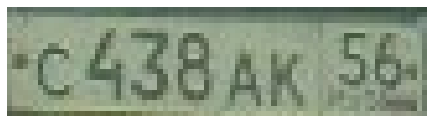

Rotated img:


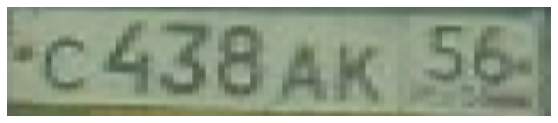

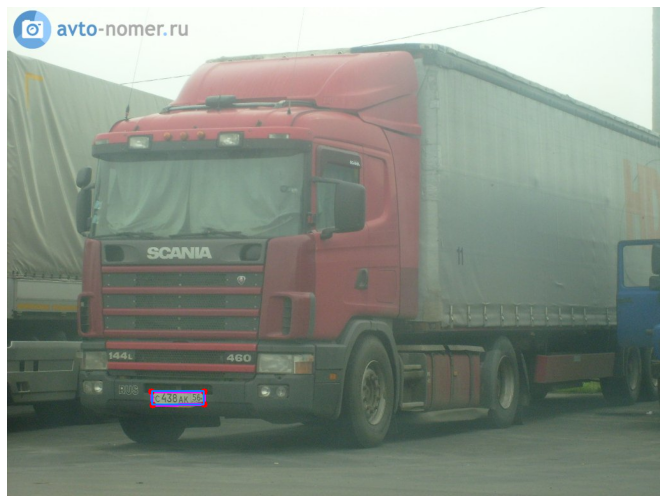

{'boxes': tensor([[227.3125, 603.8743, 308.3651, 624.3237],
         [214.1341, 373.2564, 323.5255, 398.4389],
         [173.2892, 589.6953, 207.2664, 612.9786],
         [185.2569, 592.8192, 315.0107, 631.8804]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9967, 0.6457, 0.4562, 0.1809], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0.

In [33]:
#visualize_prediction_plate(np.random.choice(test_images), model, id_to_name={1: 'plate'}, thresh=0.95)
visualize_prediction_plate(test_images[0], model, id_to_name={1: 'plate'}, thresh=THRESHOLD_SCORE)

### d) Предсказываем bounding box-ы и маску. 

- Маску превращаем в 4-угольный полигон. Сохраняем предсказания в json
- Если маска не приближается 4-угольником (редко такое бывает, бинарный поиск по гиперпараметру не работает), то просто записываем координаты bounding box 

In [42]:


preds = []
model.eval()

ii = 0
for file in tqdm.tqdm(test_images, position=0, leave=False):

#     img = Image.open(file).convert('RGB')
    img = cv2.imread(file)
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        if score > THRESHOLD_SCORE:            
            # В разных версиях opencv этот метод возвращает разное число параметров
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            #_,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })
#     print(pred)
#     if len(preds) > 10:
#         break

    preds.append(pred)   

    
with open(os.path.join(DATA_PATH, 'test.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

  5%|▌         | 166/3188 [00:19<05:56,  8.48it/s]

simplify_contour didnt coverege


# 2. Распознаем номера

### a) Датасет для распознавания номеров

Из особенностей - на каждый номер мы генерируем bounding box + вырезаем по точкам и превращаем в прямоугольник наш 4-угольник по данным точкам. Т.е. 2 картинки на номер.

In [9]:
abc = "0123456789ABCEHKMOPTXY"

class OCRDataset(Dataset):
    def __init__(self, data_path, alphabet, transforms=None):
        self.data_path = data_path
        self.transforms = transforms
        self.alphabet = alphabet
        self.image_names, self.texts = [], []
        self.image_names, self.texts = self._parse_root_(data_path)

    def _parse_root_(self, data_path):
        image_names, texts = [], []
        for (dirpath, dirnames, filenames) in os.walk(data_path):
            for i, file in enumerate(filenames):
                image_name = file
                text, _ = os.path.splitext(file)
                texts.append(text)
                image_names.append(image_name)
        return image_names, texts

        
    def __getitem__(self, idx):
        image_name = os.path.join(self.data_path, self.image_names[idx])
        text = self.texts[idx]
        
        img = cv2.imread(image_name)

        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    def __len__(self):
        return len(self.texts)
    
    
class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img
    
my_ocr_transforms = transforms.Compose([
#     Resize(size=(320, 64)),
    transforms.ToTensor()
])

def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

train_ocr_dataset = OCRDataset(
    data_path=OCR_PATH, 
    alphabet=abc,
    transforms=my_ocr_transforms
)
val_ocr_dataset = OCRDataset(
    data_path=OCR_PATH, 
    alphabet=abc,
    transforms=my_ocr_transforms
)

def collate_fn_ocr(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

train_ocr_loader = DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=0, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True # Чтобы повернутые дубли картинок не шли подряд
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn_ocr, 
    timeout=0,
)

gc.collect()

0

### b) Модель для распознования текста номера

Взял RCNN из семинара

In [10]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(64, 320), 
        cnn_output_len=20,
        rnn_hidden_size=128, 
        rnn_num_layers=2, 
        rnn_dropout=0.3, 
        rnn_bidirectional=False
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

### c) Обучаем модель для распознавания текста номера

In [11]:
crnn = CRNN()
# crnn.load_state_dict(torch.load(OCR_MODEL_PATH))
crnn.to(device);

In [24]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=1e-4, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, verbose=True)

In [25]:
# Здесь тоже оставил пока обучение без валидации. 
# Может, здесь и стоит валидировать. 
# Но опять же, 1-2 эпох хватает, а значит модель видит почти все данные 
# в первый раз и лосс на трейне вполне отражает реальность

crnn.train()
for epoch in range(2):
    epoch_losses = []
    print_loss = []
    
    for i, batch in enumerate(tqdm.tqdm(train_ocr_loader, total=len(train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 
    
        epoch_losses.append(loss.item())

    print(i, np.mean(epoch_losses))

  0%|          | 21/5207 [00:01<07:30, 11.52it/s]

Loss: 7.0899215


  1%|          | 41/5207 [00:03<07:31, 11.45it/s]

Loss: 5.1387506


  1%|          | 61/5207 [00:05<07:40, 11.18it/s]

Loss: 4.0073470


  2%|▏         | 81/5207 [00:07<08:11, 10.43it/s]

Loss: 3.7365276


  2%|▏         | 101/5207 [00:09<07:31, 11.31it/s]

Loss: 3.6011000


  2%|▏         | 121/5207 [00:10<06:28, 13.09it/s]

Loss: 3.4892950


  3%|▎         | 141/5207 [00:12<05:59, 14.10it/s]

Loss: 3.4428589


  3%|▎         | 161/5207 [00:13<05:54, 14.23it/s]

Loss: 3.3872511


  3%|▎         | 181/5207 [00:14<05:54, 14.19it/s]

Loss: 3.3450733


  4%|▍         | 201/5207 [00:16<05:53, 14.16it/s]

Loss: 3.3156290


  4%|▍         | 221/5207 [00:17<05:50, 14.22it/s]

Loss: 3.2873439


  5%|▍         | 241/5207 [00:19<05:59, 13.82it/s]

Loss: 3.2575010


  5%|▌         | 261/5207 [00:20<06:55, 11.89it/s]

Loss: 3.2376150


  5%|▌         | 281/5207 [00:22<07:10, 11.43it/s]

Loss: 3.2049482


  6%|▌         | 301/5207 [00:24<07:09, 11.41it/s]

Loss: 3.1799406


  6%|▌         | 321/5207 [00:26<07:28, 10.89it/s]

Loss: 3.1483345


  7%|▋         | 341/5207 [00:28<07:03, 11.48it/s]

Loss: 3.1202645


  7%|▋         | 361/5207 [00:29<06:55, 11.67it/s]

Loss: 3.0987017


  7%|▋         | 381/5207 [00:31<07:00, 11.49it/s]

Loss: 3.0783890


  8%|▊         | 401/5207 [00:33<07:00, 11.43it/s]

Loss: 3.0399888


  8%|▊         | 421/5207 [00:34<07:01, 11.36it/s]

Loss: 3.0247047


  8%|▊         | 441/5207 [00:36<06:52, 11.56it/s]

Loss: 2.9975654


  9%|▉         | 461/5207 [00:38<06:43, 11.77it/s]

Loss: 2.9615178


  9%|▉         | 481/5207 [00:40<06:51, 11.48it/s]

Loss: 2.9461893


 10%|▉         | 501/5207 [00:41<06:56, 11.30it/s]

Loss: 2.9202037


 10%|█         | 521/5207 [00:43<06:53, 11.34it/s]

Loss: 2.8886180


 10%|█         | 541/5207 [00:45<06:49, 11.39it/s]

Loss: 2.8684959


 11%|█         | 561/5207 [00:47<06:46, 11.42it/s]

Loss: 2.8571242


 11%|█         | 581/5207 [00:48<05:49, 13.25it/s]

Loss: 2.8284693


 12%|█▏        | 601/5207 [00:50<06:51, 11.19it/s]

Loss: 2.8089342


 12%|█▏        | 621/5207 [00:52<06:41, 11.42it/s]

Loss: 2.7705527


 12%|█▏        | 642/5207 [00:54<07:12, 10.57it/s]

Loss: 2.7631423


 13%|█▎        | 662/5207 [00:56<06:50, 11.08it/s]

Loss: 2.7279667


 13%|█▎        | 682/5207 [00:57<05:29, 13.73it/s]

Loss: 2.7072347


 13%|█▎        | 702/5207 [00:59<06:25, 11.67it/s]

Loss: 2.6848466


 14%|█▍        | 722/5207 [01:01<06:32, 11.43it/s]

Loss: 2.6424635


 14%|█▍        | 742/5207 [01:02<05:28, 13.58it/s]

Loss: 2.6343274


 15%|█▍        | 762/5207 [01:04<06:18, 11.74it/s]

Loss: 2.6086846


 15%|█▌        | 782/5207 [01:06<06:22, 11.56it/s]

Loss: 2.5927733


 15%|█▌        | 802/5207 [01:07<05:11, 14.15it/s]

Loss: 2.5507228


 16%|█▌        | 822/5207 [01:09<06:18, 11.58it/s]

Loss: 2.5146395


 16%|█▌        | 842/5207 [01:11<06:22, 11.41it/s]

Loss: 2.4841178


 17%|█▋        | 862/5207 [01:12<06:19, 11.44it/s]

Loss: 2.4692535


 17%|█▋        | 882/5207 [01:14<06:17, 11.45it/s]

Loss: 2.4508728


 17%|█▋        | 902/5207 [01:16<06:15, 11.46it/s]

Loss: 2.4351527


 18%|█▊        | 922/5207 [01:18<06:12, 11.50it/s]

Loss: 2.3844842


 18%|█▊        | 942/5207 [01:19<06:14, 11.38it/s]

Loss: 2.3576717


 18%|█▊        | 962/5207 [01:21<06:15, 11.30it/s]

Loss: 2.3542284


 19%|█▉        | 982/5207 [01:23<06:12, 11.34it/s]

Loss: 2.2992695


 19%|█▉        | 1002/5207 [01:25<06:19, 11.07it/s]

Loss: 2.2473671


 20%|█▉        | 1022/5207 [01:27<06:08, 11.35it/s]

Loss: 2.2694421


 20%|██        | 1042/5207 [01:28<06:03, 11.47it/s]

Loss: 2.1982215


 20%|██        | 1062/5207 [01:30<06:05, 11.33it/s]

Loss: 2.1636091


 21%|██        | 1082/5207 [01:32<05:16, 13.04it/s]

Loss: 2.1229269


 21%|██        | 1102/5207 [01:33<04:47, 14.26it/s]

Loss: 2.0783799


 22%|██▏       | 1122/5207 [01:35<04:47, 14.22it/s]

Loss: 2.0188517


 22%|██▏       | 1142/5207 [01:36<04:43, 14.35it/s]

Loss: 1.9743392


 22%|██▏       | 1162/5207 [01:38<05:48, 11.60it/s]

Loss: 1.9551356


 23%|██▎       | 1182/5207 [01:39<05:50, 11.50it/s]

Loss: 1.8929085


 23%|██▎       | 1202/5207 [01:41<05:49, 11.46it/s]

Loss: 1.8590085


 23%|██▎       | 1222/5207 [01:43<05:46, 11.49it/s]

Loss: 1.8256588


 24%|██▍       | 1242/5207 [01:45<05:56, 11.14it/s]

Loss: 1.7813220


 24%|██▍       | 1262/5207 [01:46<05:43, 11.49it/s]

Loss: 1.7571294


 25%|██▍       | 1282/5207 [01:48<05:42, 11.45it/s]

Loss: 1.7146148


 25%|██▌       | 1302/5207 [01:50<05:40, 11.45it/s]

Loss: 1.6841258


 25%|██▌       | 1322/5207 [01:52<05:40, 11.42it/s]

Loss: 1.6317160


 26%|██▌       | 1342/5207 [01:53<05:37, 11.46it/s]

Loss: 1.6036617


 26%|██▌       | 1362/5207 [01:55<05:34, 11.49it/s]

Loss: 1.5686159


 27%|██▋       | 1382/5207 [01:57<05:33, 11.45it/s]

Loss: 1.5077424


 27%|██▋       | 1402/5207 [01:59<05:33, 11.42it/s]

Loss: 1.5114137


 27%|██▋       | 1422/5207 [02:00<05:30, 11.47it/s]

Loss: 1.4620356


 28%|██▊       | 1442/5207 [02:02<04:59, 12.57it/s]

Loss: 1.4286624


 28%|██▊       | 1462/5207 [02:04<04:21, 14.31it/s]

Loss: 1.3975686


 28%|██▊       | 1482/5207 [02:05<05:21, 11.58it/s]

Loss: 1.3258757


 29%|██▉       | 1502/5207 [02:07<05:21, 11.52it/s]

Loss: 1.2700494


 29%|██▉       | 1522/5207 [02:09<05:23, 11.40it/s]

Loss: 1.2100755


 30%|██▉       | 1542/5207 [02:11<05:13, 11.70it/s]

Loss: 1.1780512


 30%|██▉       | 1562/5207 [02:12<05:21, 11.34it/s]

Loss: 1.1785545


 30%|███       | 1582/5207 [02:14<05:14, 11.54it/s]

Loss: 1.0805692


 31%|███       | 1602/5207 [02:16<05:14, 11.44it/s]

Loss: 1.0140488


 31%|███       | 1622/5207 [02:17<05:10, 11.54it/s]

Loss: 0.9693781


 32%|███▏      | 1642/5207 [02:19<05:09, 11.53it/s]

Loss: 0.9430397


 32%|███▏      | 1662/5207 [02:21<04:14, 13.93it/s]

Loss: 0.9267987


 32%|███▏      | 1682/5207 [02:22<04:05, 14.35it/s]

Loss: 0.8549918


 33%|███▎      | 1702/5207 [02:24<04:26, 13.14it/s]

Loss: 0.8271894


 33%|███▎      | 1722/5207 [02:25<05:02, 11.52it/s]

Loss: 0.7903078


 33%|███▎      | 1742/5207 [02:27<05:01, 11.48it/s]

Loss: 0.7904927


 34%|███▍      | 1762/5207 [02:29<04:04, 14.09it/s]

Loss: 0.7612163


 34%|███▍      | 1782/5207 [02:30<04:29, 12.73it/s]

Loss: 0.6818554


 35%|███▍      | 1802/5207 [02:31<03:58, 14.27it/s]

Loss: 0.6390473


 35%|███▍      | 1822/5207 [02:33<03:56, 14.34it/s]

Loss: 0.6784473


 35%|███▌      | 1842/5207 [02:34<03:54, 14.34it/s]

Loss: 0.6333881


 36%|███▌      | 1862/5207 [02:36<03:55, 14.21it/s]

Loss: 0.6139657


 36%|███▌      | 1882/5207 [02:37<03:53, 14.27it/s]

Loss: 0.6187339


 37%|███▋      | 1902/5207 [02:39<03:51, 14.31it/s]

Loss: 0.5725088


 37%|███▋      | 1922/5207 [02:40<04:44, 11.56it/s]

Loss: 0.4930034


 37%|███▋      | 1942/5207 [02:42<04:45, 11.45it/s]

Loss: 0.5617114


 38%|███▊      | 1962/5207 [02:44<04:43, 11.45it/s]

Loss: 0.5786447


 38%|███▊      | 1982/5207 [02:45<04:40, 11.49it/s]

Loss: 0.4774714


 38%|███▊      | 2002/5207 [02:47<04:38, 11.50it/s]

Loss: 0.4819226


 39%|███▉      | 2022/5207 [02:49<04:38, 11.45it/s]

Loss: 0.5215152


 39%|███▉      | 2042/5207 [02:51<04:37, 11.40it/s]

Loss: 0.4157240


 40%|███▉      | 2062/5207 [02:52<04:33, 11.51it/s]

Loss: 0.3826653


 40%|███▉      | 2082/5207 [02:54<04:31, 11.52it/s]

Loss: 0.4480991


 40%|████      | 2102/5207 [02:56<04:31, 11.45it/s]

Loss: 0.3858132


 41%|████      | 2122/5207 [02:58<04:29, 11.44it/s]

Loss: 0.4148149
Epoch   106: reducing learning rate of group 0 to 5.0000e-05.


 41%|████      | 2142/5207 [02:59<04:26, 11.49it/s]

Loss: 0.4531882


 42%|████▏     | 2162/5207 [03:01<04:25, 11.46it/s]

Loss: 0.4133831


 42%|████▏     | 2182/5207 [03:03<04:25, 11.38it/s]

Loss: 0.3334175


 42%|████▏     | 2202/5207 [03:05<04:21, 11.48it/s]

Loss: 0.3794059


 43%|████▎     | 2222/5207 [03:06<04:19, 11.50it/s]

Loss: 0.3132900


 43%|████▎     | 2242/5207 [03:08<04:18, 11.45it/s]

Loss: 0.4125048


 43%|████▎     | 2262/5207 [03:10<04:18, 11.40it/s]

Loss: 0.3804509


 44%|████▍     | 2282/5207 [03:12<04:15, 11.43it/s]

Loss: 0.3161688
Epoch   114: reducing learning rate of group 0 to 2.5000e-05.


 44%|████▍     | 2302/5207 [03:13<04:15, 11.39it/s]

Loss: 0.3766017


 45%|████▍     | 2322/5207 [03:15<04:12, 11.44it/s]

Loss: 0.3553017


 45%|████▍     | 2342/5207 [03:17<04:10, 11.45it/s]

Loss: 0.2803982


 45%|████▌     | 2362/5207 [03:19<04:10, 11.37it/s]

Loss: 0.3794031


 46%|████▌     | 2382/5207 [03:20<04:14, 11.11it/s]

Loss: 0.3086429


 46%|████▌     | 2402/5207 [03:22<04:03, 11.51it/s]

Loss: 0.3143852
Epoch   120: reducing learning rate of group 0 to 1.2500e-05.


 47%|████▋     | 2422/5207 [03:24<03:20, 13.90it/s]

Loss: 0.2499750


 47%|████▋     | 2442/5207 [03:25<03:16, 14.05it/s]

Loss: 0.2537213


 47%|████▋     | 2462/5207 [03:27<03:12, 14.24it/s]

Loss: 0.2310070


 48%|████▊     | 2482/5207 [03:28<03:10, 14.34it/s]

Loss: 0.3171514


 48%|████▊     | 2502/5207 [03:30<03:43, 12.12it/s]

Loss: 0.2404122


 48%|████▊     | 2522/5207 [03:31<03:53, 11.50it/s]

Loss: 0.3834134
Epoch   126: reducing learning rate of group 0 to 6.2500e-06.


 49%|████▉     | 2542/5207 [03:33<03:52, 11.47it/s]

Loss: 0.2787784


 49%|████▉     | 2562/5207 [03:35<03:24, 12.94it/s]

Loss: 0.2382419


 50%|████▉     | 2582/5207 [03:36<03:04, 14.27it/s]

Loss: 0.3378663
Epoch   129: reducing learning rate of group 0 to 3.1250e-06.


 50%|████▉     | 2602/5207 [03:38<03:25, 12.65it/s]

Loss: 0.3182601


 50%|█████     | 2622/5207 [03:39<03:27, 12.46it/s]

Loss: 0.3118564


 51%|█████     | 2642/5207 [03:41<03:42, 11.52it/s]

Loss: 0.3379545
Epoch   132: reducing learning rate of group 0 to 1.5625e-06.


 51%|█████     | 2662/5207 [03:43<03:42, 11.45it/s]

Loss: 0.3780760


 52%|█████▏    | 2682/5207 [03:45<03:39, 11.49it/s]

Loss: 0.3002150


 52%|█████▏    | 2702/5207 [03:46<03:36, 11.55it/s]

Loss: 0.4084702
Epoch   135: reducing learning rate of group 0 to 7.8125e-07.


 52%|█████▏    | 2722/5207 [03:48<03:36, 11.45it/s]

Loss: 0.3539087


 53%|█████▎    | 2742/5207 [03:50<03:36, 11.37it/s]

Loss: 0.3086098


 53%|█████▎    | 2762/5207 [03:52<03:33, 11.44it/s]

Loss: 0.2897782
Epoch   138: reducing learning rate of group 0 to 3.9063e-07.


 53%|█████▎    | 2782/5207 [03:53<03:32, 11.41it/s]

Loss: 0.2888770


 54%|█████▍    | 2802/5207 [03:55<03:29, 11.47it/s]

Loss: 0.3243510


 54%|█████▍    | 2822/5207 [03:57<03:30, 11.32it/s]

Loss: 0.2913235
Epoch   141: reducing learning rate of group 0 to 1.9531e-07.


 55%|█████▍    | 2842/5207 [03:59<03:27, 11.41it/s]

Loss: 0.3870524


 55%|█████▍    | 2862/5207 [04:00<03:24, 11.45it/s]

Loss: 0.2657488


 55%|█████▌    | 2882/5207 [04:02<03:22, 11.50it/s]

Loss: 0.3478643
Epoch   144: reducing learning rate of group 0 to 9.7656e-08.


 56%|█████▌    | 2902/5207 [04:04<03:20, 11.47it/s]

Loss: 0.2842768


 56%|█████▌    | 2922/5207 [04:05<03:18, 11.53it/s]

Loss: 0.3287096


 57%|█████▋    | 2942/5207 [04:07<03:18, 11.43it/s]

Loss: 0.3028573
Epoch   147: reducing learning rate of group 0 to 4.8828e-08.


 57%|█████▋    | 2962/5207 [04:09<03:15, 11.47it/s]

Loss: 0.2603801


 57%|█████▋    | 2982/5207 [04:11<03:15, 11.37it/s]

Loss: 0.3419487


 58%|█████▊    | 3002/5207 [04:13<03:15, 11.30it/s]

Loss: 0.3652785
Epoch   150: reducing learning rate of group 0 to 2.4414e-08.


 58%|█████▊    | 3022/5207 [04:14<03:10, 11.50it/s]

Loss: 0.3828976


 58%|█████▊    | 3042/5207 [04:16<03:11, 11.28it/s]

Loss: 0.2824656


 59%|█████▉    | 3062/5207 [04:18<03:09, 11.32it/s]

Loss: 0.3698455
Epoch   153: reducing learning rate of group 0 to 1.2207e-08.


 59%|█████▉    | 3082/5207 [04:20<03:06, 11.40it/s]

Loss: 0.3625173


 60%|█████▉    | 3102/5207 [04:21<03:04, 11.44it/s]

Loss: 0.3411816


 60%|█████▉    | 3122/5207 [04:23<03:01, 11.46it/s]

Loss: 0.3216582


 60%|██████    | 3142/5207 [04:25<03:01, 11.37it/s]

Loss: 0.2764573


 61%|██████    | 3162/5207 [04:27<02:58, 11.45it/s]

Loss: 0.3736523


 61%|██████    | 3182/5207 [04:28<02:56, 11.47it/s]

Loss: 0.2561240


 61%|██████▏   | 3202/5207 [04:30<02:56, 11.39it/s]

Loss: 0.2977478


 62%|██████▏   | 3222/5207 [04:32<02:40, 12.35it/s]

Loss: 0.2889592


 62%|██████▏   | 3242/5207 [04:33<02:50, 11.55it/s]

Loss: 0.2552201


 63%|██████▎   | 3262/5207 [04:35<02:48, 11.53it/s]

Loss: 0.3824400


 63%|██████▎   | 3282/5207 [04:37<02:16, 14.06it/s]

Loss: 0.3181093


 63%|██████▎   | 3302/5207 [04:38<02:12, 14.34it/s]

Loss: 0.4458749


 64%|██████▍   | 3322/5207 [04:40<02:43, 11.54it/s]

Loss: 0.2780904


 64%|██████▍   | 3342/5207 [04:42<02:43, 11.40it/s]

Loss: 0.3034824


 65%|██████▍   | 3362/5207 [04:43<02:41, 11.40it/s]

Loss: 0.2616969


 65%|██████▍   | 3382/5207 [04:45<02:40, 11.38it/s]

Loss: 0.3169862


 65%|██████▌   | 3402/5207 [04:47<02:37, 11.46it/s]

Loss: 0.3359304


 66%|██████▌   | 3422/5207 [04:49<02:36, 11.37it/s]

Loss: 0.3326677


 66%|██████▌   | 3442/5207 [04:50<02:34, 11.42it/s]

Loss: 0.3073607


 66%|██████▋   | 3462/5207 [04:52<02:31, 11.48it/s]

Loss: 0.3735165


 67%|██████▋   | 3482/5207 [04:54<02:30, 11.46it/s]

Loss: 0.3396417


 67%|██████▋   | 3502/5207 [04:56<02:29, 11.43it/s]

Loss: 0.3037760


 68%|██████▊   | 3522/5207 [04:57<02:26, 11.52it/s]

Loss: 0.3390560


 68%|██████▊   | 3542/5207 [04:59<02:24, 11.49it/s]

Loss: 0.2926873


 68%|██████▊   | 3562/5207 [05:01<02:23, 11.45it/s]

Loss: 0.3439572


 69%|██████▉   | 3582/5207 [05:03<02:22, 11.40it/s]

Loss: 0.2668399


 69%|██████▉   | 3602/5207 [05:04<02:19, 11.47it/s]

Loss: 0.3161611


 70%|██████▉   | 3622/5207 [05:06<02:18, 11.43it/s]

Loss: 0.3857540


 70%|██████▉   | 3642/5207 [05:08<02:16, 11.45it/s]

Loss: 0.3144119


 70%|███████   | 3662/5207 [05:10<02:15, 11.42it/s]

Loss: 0.3041104


 71%|███████   | 3682/5207 [05:11<02:13, 11.38it/s]

Loss: 0.3540709


 71%|███████   | 3702/5207 [05:13<02:12, 11.35it/s]

Loss: 0.3068880


 71%|███████▏  | 3722/5207 [05:15<02:09, 11.46it/s]

Loss: 0.2940070


 72%|███████▏  | 3742/5207 [05:17<02:08, 11.40it/s]

Loss: 0.2930780


 72%|███████▏  | 3762/5207 [05:18<02:07, 11.30it/s]

Loss: 0.3480858


 73%|███████▎  | 3782/5207 [05:20<02:04, 11.43it/s]

Loss: 0.3015484


 73%|███████▎  | 3802/5207 [05:22<02:00, 11.71it/s]

Loss: 0.3062037


 73%|███████▎  | 3822/5207 [05:24<02:02, 11.33it/s]

Loss: 0.2562273


 74%|███████▍  | 3842/5207 [05:25<01:59, 11.42it/s]

Loss: 0.3340421


 74%|███████▍  | 3862/5207 [05:27<01:56, 11.50it/s]

Loss: 0.2821863


 75%|███████▍  | 3882/5207 [05:29<01:56, 11.39it/s]

Loss: 0.3258629


 75%|███████▍  | 3902/5207 [05:31<01:54, 11.39it/s]

Loss: 0.3578766


 75%|███████▌  | 3922/5207 [05:33<01:52, 11.46it/s]

Loss: 0.3609850


 76%|███████▌  | 3942/5207 [05:34<01:50, 11.48it/s]

Loss: 0.3051357


 76%|███████▌  | 3962/5207 [05:36<01:47, 11.53it/s]

Loss: 0.3033882


 76%|███████▋  | 3982/5207 [05:37<01:27, 14.08it/s]

Loss: 0.2704629


 77%|███████▋  | 4002/5207 [05:39<01:24, 14.26it/s]

Loss: 0.3143132


 77%|███████▋  | 4022/5207 [05:40<01:23, 14.23it/s]

Loss: 0.3305842


 78%|███████▊  | 4042/5207 [05:42<01:21, 14.23it/s]

Loss: 0.3461679


 78%|███████▊  | 4062/5207 [05:43<01:36, 11.86it/s]

Loss: 0.3013591


 78%|███████▊  | 4082/5207 [05:45<01:38, 11.46it/s]

Loss: 0.3253212


 79%|███████▉  | 4102/5207 [05:47<01:38, 11.26it/s]

Loss: 0.3767564


 79%|███████▉  | 4122/5207 [05:49<01:34, 11.45it/s]

Loss: 0.2499537


 80%|███████▉  | 4142/5207 [05:50<01:33, 11.36it/s]

Loss: 0.2764323


 80%|███████▉  | 4162/5207 [05:52<01:37, 10.71it/s]

Loss: 0.2678064


 80%|████████  | 4182/5207 [05:54<01:29, 11.43it/s]

Loss: 0.2804681


 81%|████████  | 4202/5207 [05:56<01:27, 11.45it/s]

Loss: 0.2963461


 81%|████████  | 4222/5207 [05:57<01:25, 11.51it/s]

Loss: 0.3505072


 81%|████████▏ | 4242/5207 [05:59<01:25, 11.32it/s]

Loss: 0.2618440


 82%|████████▏ | 4262/5207 [06:01<01:23, 11.26it/s]

Loss: 0.3670886


 82%|████████▏ | 4282/5207 [06:03<01:21, 11.36it/s]

Loss: 0.2608871


 83%|████████▎ | 4302/5207 [06:04<01:19, 11.37it/s]

Loss: 0.3847484


 83%|████████▎ | 4322/5207 [06:06<01:18, 11.31it/s]

Loss: 0.3147130


 83%|████████▎ | 4342/5207 [06:08<01:16, 11.26it/s]

Loss: 0.2739473


 84%|████████▍ | 4362/5207 [06:10<01:13, 11.46it/s]

Loss: 0.2820224


 84%|████████▍ | 4382/5207 [06:12<01:11, 11.59it/s]

Loss: 0.3252869


 85%|████████▍ | 4402/5207 [06:13<01:08, 11.68it/s]

Loss: 0.3284256


 85%|████████▍ | 4422/5207 [06:15<01:07, 11.63it/s]

Loss: 0.3336118


 85%|████████▌ | 4442/5207 [06:17<01:06, 11.59it/s]

Loss: 0.2651526


 86%|████████▌ | 4462/5207 [06:18<01:04, 11.63it/s]

Loss: 0.2975604


 86%|████████▌ | 4482/5207 [06:20<01:02, 11.60it/s]

Loss: 0.3198783


 86%|████████▋ | 4502/5207 [06:22<01:00, 11.65it/s]

Loss: 0.3336878


 87%|████████▋ | 4522/5207 [06:24<00:59, 11.49it/s]

Loss: 0.3320253


 87%|████████▋ | 4542/5207 [06:25<00:56, 11.67it/s]

Loss: 0.2453495


 88%|████████▊ | 4562/5207 [06:27<00:55, 11.66it/s]

Loss: 0.3521288


 88%|████████▊ | 4582/5207 [06:29<00:54, 11.57it/s]

Loss: 0.2814650


 88%|████████▊ | 4602/5207 [06:30<00:52, 11.62it/s]

Loss: 0.3061325


 89%|████████▉ | 4622/5207 [06:32<00:50, 11.68it/s]

Loss: 0.2446665


 89%|████████▉ | 4642/5207 [06:34<00:48, 11.61it/s]

Loss: 0.2681931


 90%|████████▉ | 4662/5207 [06:36<00:47, 11.58it/s]

Loss: 0.3194507


 90%|████████▉ | 4682/5207 [06:37<00:45, 11.61it/s]

Loss: 0.3353970


 90%|█████████ | 4702/5207 [06:39<00:36, 13.90it/s]

Loss: 0.3362728


 91%|█████████ | 4722/5207 [06:40<00:32, 14.77it/s]

Loss: 0.2283994


 91%|█████████ | 4742/5207 [06:42<00:31, 14.82it/s]

Loss: 0.3781468


 91%|█████████▏| 4762/5207 [06:43<00:29, 14.87it/s]

Loss: 0.3078897


 92%|█████████▏| 4782/5207 [06:44<00:28, 14.93it/s]

Loss: 0.3574514


 92%|█████████▏| 4802/5207 [06:46<00:27, 14.72it/s]

Loss: 0.2827711


 93%|█████████▎| 4822/5207 [06:47<00:25, 14.89it/s]

Loss: 0.2932802


 93%|█████████▎| 4842/5207 [06:48<00:24, 14.90it/s]

Loss: 0.3937887


 93%|█████████▎| 4862/5207 [06:50<00:23, 14.74it/s]

Loss: 0.2714874


 94%|█████████▍| 4882/5207 [06:51<00:21, 14.86it/s]

Loss: 0.3211183


 94%|█████████▍| 4902/5207 [06:52<00:20, 14.92it/s]

Loss: 0.2687464


 95%|█████████▍| 4922/5207 [06:54<00:19, 14.90it/s]

Loss: 0.2831349


 95%|█████████▍| 4942/5207 [06:55<00:17, 14.90it/s]

Loss: 0.2766141


 95%|█████████▌| 4962/5207 [06:56<00:16, 14.62it/s]

Loss: 0.2531051


 96%|█████████▌| 4982/5207 [06:58<00:15, 14.83it/s]

Loss: 0.3091073


 96%|█████████▌| 5002/5207 [06:59<00:13, 14.87it/s]

Loss: 0.2724705


 96%|█████████▋| 5022/5207 [07:00<00:12, 14.80it/s]

Loss: 0.2808778


 97%|█████████▋| 5042/5207 [07:02<00:11, 14.25it/s]

Loss: 0.2687174


 97%|█████████▋| 5062/5207 [07:03<00:09, 14.85it/s]

Loss: 0.2850619


 98%|█████████▊| 5082/5207 [07:05<00:08, 14.76it/s]

Loss: 0.3791204


 98%|█████████▊| 5102/5207 [07:06<00:08, 11.84it/s]

Loss: 0.2329890


 98%|█████████▊| 5122/5207 [07:08<00:05, 14.41it/s]

Loss: 0.3462888


 99%|█████████▉| 5142/5207 [07:09<00:04, 14.90it/s]

Loss: 0.3606598


 99%|█████████▉| 5162/5207 [07:10<00:03, 14.84it/s]

Loss: 0.2882891


100%|█████████▉| 5182/5207 [07:12<00:01, 14.67it/s]

Loss: 0.3286910


100%|█████████▉| 5202/5207 [07:13<00:00, 14.81it/s]

Loss: 0.3286398


  0%|          | 2/5207 [00:00<06:17, 13.78it/s]   

5206 1.0252566509290784


  0%|          | 22/5207 [00:01<05:50, 14.77it/s]

Loss: 0.2738905


  1%|          | 42/5207 [00:02<05:48, 14.83it/s]

Loss: 0.3659780


  1%|          | 62/5207 [00:04<05:49, 14.72it/s]

Loss: 0.2462658


  2%|▏         | 82/5207 [00:05<05:45, 14.85it/s]

Loss: 0.3430692


  2%|▏         | 102/5207 [00:06<05:56, 14.31it/s]

Loss: 0.2946901


  2%|▏         | 122/5207 [00:08<07:21, 11.53it/s]

Loss: 0.3478065


  3%|▎         | 142/5207 [00:10<06:27, 13.06it/s]

Loss: 0.3413183


  3%|▎         | 162/5207 [00:11<07:11, 11.70it/s]

Loss: 0.2737485


  3%|▎         | 182/5207 [00:13<07:12, 11.63it/s]

Loss: 0.3170105


  4%|▍         | 202/5207 [00:15<07:24, 11.27it/s]

Loss: 0.3882579


  4%|▍         | 222/5207 [00:17<07:10, 11.57it/s]

Loss: 0.3337474


  5%|▍         | 242/5207 [00:18<07:06, 11.64it/s]

Loss: 0.3094402


  5%|▌         | 262/5207 [00:20<07:04, 11.66it/s]

Loss: 0.3329056


  5%|▌         | 282/5207 [00:22<07:06, 11.55it/s]

Loss: 0.2977869


  6%|▌         | 302/5207 [00:24<07:00, 11.67it/s]

Loss: 0.2587861


  6%|▌         | 322/5207 [00:25<06:59, 11.64it/s]

Loss: 0.3122048


  7%|▋         | 342/5207 [00:27<05:32, 14.65it/s]

Loss: 0.3884826


  7%|▋         | 362/5207 [00:28<06:30, 12.42it/s]

Loss: 0.3638779


  7%|▋         | 382/5207 [00:30<05:29, 14.64it/s]

Loss: 0.2702187


  8%|▊         | 402/5207 [00:31<05:28, 14.63it/s]

Loss: 0.3508463


  8%|▊         | 422/5207 [00:32<05:21, 14.87it/s]

Loss: 0.3374394


  8%|▊         | 442/5207 [00:34<05:21, 14.81it/s]

Loss: 0.2916853


  9%|▉         | 462/5207 [00:35<05:19, 14.83it/s]

Loss: 0.3512240


  9%|▉         | 482/5207 [00:36<05:17, 14.90it/s]

Loss: 0.2713108


 10%|▉         | 502/5207 [00:38<05:20, 14.70it/s]

Loss: 0.2982648


 10%|█         | 522/5207 [00:39<05:15, 14.84it/s]

Loss: 0.3221033


 10%|█         | 542/5207 [00:40<05:13, 14.87it/s]

Loss: 0.2795691


 11%|█         | 562/5207 [00:42<05:16, 14.68it/s]

Loss: 0.3236659


 11%|█         | 582/5207 [00:43<05:12, 14.82it/s]

Loss: 0.2987134


 12%|█▏        | 602/5207 [00:44<05:08, 14.91it/s]

Loss: 0.2542977


 12%|█▏        | 622/5207 [00:46<05:10, 14.77it/s]

Loss: 0.2888686


 12%|█▏        | 642/5207 [00:47<05:07, 14.82it/s]

Loss: 0.2528547


 13%|█▎        | 662/5207 [00:49<06:11, 12.23it/s]

Loss: 0.2605919


 13%|█▎        | 682/5207 [00:50<06:26, 11.71it/s]

Loss: 0.2734256


 13%|█▎        | 702/5207 [00:52<05:33, 13.49it/s]

Loss: 0.2697719


 14%|█▍        | 722/5207 [00:53<05:02, 14.85it/s]

Loss: 0.3443125


 14%|█▍        | 742/5207 [00:55<05:12, 14.30it/s]

Loss: 0.3324870


 15%|█▍        | 762/5207 [00:56<05:00, 14.78it/s]

Loss: 0.3804596


 15%|█▌        | 782/5207 [00:57<04:57, 14.89it/s]

Loss: 0.2775112


 15%|█▌        | 802/5207 [00:59<04:59, 14.73it/s]

Loss: 0.3000637


 16%|█▌        | 822/5207 [01:00<04:56, 14.80it/s]

Loss: 0.2785363


 16%|█▌        | 842/5207 [01:01<04:54, 14.84it/s]

Loss: 0.2712803


 17%|█▋        | 862/5207 [01:03<05:08, 14.08it/s]

Loss: 0.2781561


 17%|█▋        | 882/5207 [01:04<04:54, 14.67it/s]

Loss: 0.3755805


 17%|█▋        | 902/5207 [01:06<04:49, 14.88it/s]

Loss: 0.2846095


 18%|█▊        | 922/5207 [01:07<04:51, 14.71it/s]

Loss: 0.2623123


 18%|█▊        | 942/5207 [01:08<04:47, 14.85it/s]

Loss: 0.2500088


 18%|█▊        | 962/5207 [01:10<04:49, 14.65it/s]

Loss: 0.2355546


 19%|█▉        | 982/5207 [01:11<04:45, 14.82it/s]

Loss: 0.2649892


 19%|█▉        | 1002/5207 [01:12<04:43, 14.81it/s]

Loss: 0.2979886


 20%|█▉        | 1022/5207 [01:14<04:45, 14.68it/s]

Loss: 0.3595444


 20%|██        | 1042/5207 [01:15<04:40, 14.86it/s]

Loss: 0.4268358


 20%|██        | 1062/5207 [01:16<04:37, 14.93it/s]

Loss: 0.3163087


 21%|██        | 1082/5207 [01:18<05:50, 11.79it/s]

Loss: 0.3226102


 21%|██        | 1102/5207 [01:20<05:57, 11.49it/s]

Loss: 0.3525581


 22%|██▏       | 1122/5207 [01:21<05:49, 11.68it/s]

Loss: 0.3433845


 22%|██▏       | 1142/5207 [01:23<05:48, 11.67it/s]

Loss: 0.2965917


 22%|██▏       | 1162/5207 [01:25<05:48, 11.62it/s]

Loss: 0.3386196


 23%|██▎       | 1182/5207 [01:27<05:46, 11.63it/s]

Loss: 0.2597830


 23%|██▎       | 1202/5207 [01:28<05:42, 11.70it/s]

Loss: 0.2939290


 23%|██▎       | 1222/5207 [01:30<05:41, 11.68it/s]

Loss: 0.3250639


 24%|██▍       | 1242/5207 [01:32<05:42, 11.57it/s]

Loss: 0.3162967


 24%|██▍       | 1262/5207 [01:33<05:38, 11.65it/s]

Loss: 0.3184052


 25%|██▍       | 1282/5207 [01:35<05:39, 11.55it/s]

Loss: 0.3452945


 25%|██▌       | 1302/5207 [01:37<05:37, 11.57it/s]

Loss: 0.2855833


 25%|██▌       | 1322/5207 [01:39<05:37, 11.51it/s]

Loss: 0.3221772


 26%|██▌       | 1342/5207 [01:40<05:31, 11.66it/s]

Loss: 0.2856383


 26%|██▌       | 1362/5207 [01:42<05:32, 11.57it/s]

Loss: 0.2270152


 27%|██▋       | 1382/5207 [01:44<05:31, 11.54it/s]

Loss: 0.2602480


 27%|██▋       | 1402/5207 [01:46<05:32, 11.45it/s]

Loss: 0.3543883


 27%|██▋       | 1422/5207 [01:47<05:25, 11.62it/s]

Loss: 0.2868550


 28%|██▊       | 1442/5207 [01:49<05:24, 11.62it/s]

Loss: 0.3767134


 28%|██▊       | 1462/5207 [01:51<05:24, 11.55it/s]

Loss: 0.3734991


 28%|██▊       | 1482/5207 [01:52<05:19, 11.64it/s]

Loss: 0.2480373


 29%|██▉       | 1502/5207 [01:54<05:20, 11.56it/s]

Loss: 0.2986484


 29%|██▉       | 1522/5207 [01:56<05:17, 11.60it/s]

Loss: 0.2788954


 30%|██▉       | 1542/5207 [01:58<05:16, 11.57it/s]

Loss: 0.3581622


 30%|██▉       | 1562/5207 [01:59<05:14, 11.57it/s]

Loss: 0.3130597


 30%|███       | 1582/5207 [02:01<04:26, 13.62it/s]

Loss: 0.2591785


 31%|███       | 1602/5207 [02:02<04:03, 14.81it/s]

Loss: 0.3599398


 31%|███       | 1622/5207 [02:04<04:06, 14.56it/s]

Loss: 0.2803568


 32%|███▏      | 1642/5207 [02:05<04:01, 14.77it/s]

Loss: 0.2273168


 32%|███▏      | 1662/5207 [02:06<04:06, 14.36it/s]

Loss: 0.3043625


 32%|███▏      | 1682/5207 [02:08<05:03, 11.61it/s]

Loss: 0.3418537


 33%|███▎      | 1702/5207 [02:10<05:04, 11.50it/s]

Loss: 0.3452286


 33%|███▎      | 1722/5207 [02:12<05:00, 11.60it/s]

Loss: 0.3411221


 33%|███▎      | 1742/5207 [02:13<04:58, 11.59it/s]

Loss: 0.3242693


 34%|███▍      | 1762/5207 [02:15<05:00, 11.47it/s]

Loss: 0.2607844


 34%|███▍      | 1782/5207 [02:17<05:15, 10.84it/s]

Loss: 0.4134929


 35%|███▍      | 1802/5207 [02:19<05:37, 10.08it/s]

Loss: 0.3076492


 35%|███▍      | 1822/5207 [02:21<05:25, 10.39it/s]

Loss: 0.2767604


 35%|███▌      | 1840/5207 [02:22<04:52, 11.49it/s]

Loss: 0.2391812


 36%|███▌      | 1860/5207 [02:24<05:06, 10.91it/s]

Loss: 0.3203374


 36%|███▌      | 1882/5207 [02:26<04:32, 12.19it/s]

Loss: 0.3321884


 36%|███▋      | 1900/5207 [02:28<04:48, 11.47it/s]

Loss: 0.2462915


 37%|███▋      | 1922/5207 [02:30<04:27, 12.27it/s]

Loss: 0.2837258


 37%|███▋      | 1942/5207 [02:32<04:53, 11.12it/s]

Loss: 0.2855562


 38%|███▊      | 1962/5207 [02:33<04:07, 13.11it/s]

Loss: 0.2451945


 38%|███▊      | 1982/5207 [02:35<04:26, 12.12it/s]

Loss: 0.3124859


 38%|███▊      | 2002/5207 [02:37<04:44, 11.25it/s]

Loss: 0.2845399


 39%|███▉      | 2021/5207 [02:39<05:06, 10.40it/s]

Loss: 0.2442706


 39%|███▉      | 2041/5207 [02:40<04:39, 11.34it/s]

Loss: 0.3521214


 40%|███▉      | 2061/5207 [02:42<04:27, 11.75it/s]

Loss: 0.2795811


 40%|███▉      | 2081/5207 [02:44<04:32, 11.46it/s]

Loss: 0.3215101


 40%|████      | 2101/5207 [02:46<04:54, 10.53it/s]

Loss: 0.2788526


 41%|████      | 2121/5207 [02:48<04:35, 11.19it/s]

Loss: 0.4021098


 41%|████      | 2141/5207 [02:49<04:38, 11.00it/s]

Loss: 0.3325858


 42%|████▏     | 2161/5207 [02:51<03:54, 12.98it/s]

Loss: 0.3236806


 42%|████▏     | 2181/5207 [02:53<03:36, 13.96it/s]

Loss: 0.2850516


 42%|████▏     | 2201/5207 [02:54<03:33, 14.07it/s]

Loss: 0.3614388


 43%|████▎     | 2221/5207 [02:55<03:29, 14.22it/s]

Loss: 0.3235741


 43%|████▎     | 2241/5207 [02:57<03:31, 14.05it/s]

Loss: 0.2751264


 43%|████▎     | 2261/5207 [02:58<03:27, 14.18it/s]

Loss: 0.2787617


 44%|████▍     | 2281/5207 [03:00<03:28, 14.03it/s]

Loss: 0.3019236


 44%|████▍     | 2301/5207 [03:01<03:29, 13.85it/s]

Loss: 0.2896685


 45%|████▍     | 2321/5207 [03:03<03:24, 14.10it/s]

Loss: 0.3075468


 45%|████▍     | 2341/5207 [03:04<03:24, 14.04it/s]

Loss: 0.3099062


 45%|████▌     | 2361/5207 [03:05<03:20, 14.19it/s]

Loss: 0.2887170


 46%|████▌     | 2381/5207 [03:07<03:20, 14.11it/s]

Loss: 0.3293198


 46%|████▌     | 2401/5207 [03:08<03:17, 14.22it/s]

Loss: 0.3293603


 46%|████▋     | 2421/5207 [03:10<03:17, 14.12it/s]

Loss: 0.2969079


 47%|████▋     | 2441/5207 [03:11<03:53, 11.85it/s]

Loss: 0.3199908


 47%|████▋     | 2461/5207 [03:13<04:00, 11.41it/s]

Loss: 0.3580329


 48%|████▊     | 2481/5207 [03:15<03:58, 11.42it/s]

Loss: 0.3309002


 48%|████▊     | 2501/5207 [03:17<03:57, 11.42it/s]

Loss: 0.3255868


 48%|████▊     | 2521/5207 [03:18<03:55, 11.39it/s]

Loss: 0.2569829


 49%|████▉     | 2541/5207 [03:20<03:52, 11.45it/s]

Loss: 0.2812789


 49%|████▉     | 2561/5207 [03:22<03:50, 11.46it/s]

Loss: 0.2664929


 50%|████▉     | 2581/5207 [03:24<03:50, 11.38it/s]

Loss: 0.2959338


 50%|████▉     | 2601/5207 [03:25<03:46, 11.49it/s]

Loss: 0.2936641


 50%|█████     | 2621/5207 [03:27<03:47, 11.37it/s]

Loss: 0.3966305


 51%|█████     | 2641/5207 [03:29<03:44, 11.45it/s]

Loss: 0.2645688


 51%|█████     | 2662/5207 [03:31<04:15,  9.95it/s]

Loss: 0.3541462


 51%|█████▏    | 2681/5207 [03:33<04:04, 10.33it/s]

Loss: 0.3291922


 52%|█████▏    | 2701/5207 [03:34<03:07, 13.39it/s]

Loss: 0.3301983


 52%|█████▏    | 2721/5207 [03:36<03:35, 11.52it/s]

Loss: 0.2546272


 53%|█████▎    | 2741/5207 [03:38<03:42, 11.09it/s]

Loss: 0.3896328


 53%|█████▎    | 2761/5207 [03:40<03:34, 11.39it/s]

Loss: 0.3611467


 53%|█████▎    | 2781/5207 [03:41<03:34, 11.32it/s]

Loss: 0.2671907


 54%|█████▍    | 2801/5207 [03:43<03:29, 11.48it/s]

Loss: 0.3013394


 54%|█████▍    | 2821/5207 [03:45<03:29, 11.40it/s]

Loss: 0.2772597


 55%|█████▍    | 2841/5207 [03:47<03:27, 11.38it/s]

Loss: 0.3127756


 55%|█████▍    | 2861/5207 [03:48<03:24, 11.46it/s]

Loss: 0.3146993


 55%|█████▌    | 2881/5207 [03:50<03:22, 11.50it/s]

Loss: 0.3593922


 56%|█████▌    | 2901/5207 [03:52<03:22, 11.41it/s]

Loss: 0.2481241


 56%|█████▌    | 2921/5207 [03:53<02:45, 13.81it/s]

Loss: 0.3325923


 56%|█████▋    | 2941/5207 [03:55<02:39, 14.23it/s]

Loss: 0.3009481


 57%|█████▋    | 2961/5207 [03:56<02:41, 13.88it/s]

Loss: 0.2311671


 57%|█████▋    | 2981/5207 [03:58<02:39, 14.00it/s]

Loss: 0.3571776


 58%|█████▊    | 3001/5207 [03:59<02:35, 14.20it/s]

Loss: 0.3011478


 58%|█████▊    | 3021/5207 [04:00<02:34, 14.18it/s]

Loss: 0.3189828


 58%|█████▊    | 3041/5207 [04:02<02:33, 14.15it/s]

Loss: 0.3134217


 59%|█████▉    | 3061/5207 [04:03<02:30, 14.27it/s]

Loss: 0.2838633


 59%|█████▉    | 3081/5207 [04:05<02:31, 14.06it/s]

Loss: 0.3528613


 60%|█████▉    | 3101/5207 [04:06<03:01, 11.59it/s]

Loss: 0.3122399


 60%|█████▉    | 3121/5207 [04:08<03:01, 11.48it/s]

Loss: 0.2911593


 60%|██████    | 3141/5207 [04:10<03:01, 11.37it/s]

Loss: 0.2686789


 61%|██████    | 3161/5207 [04:12<02:50, 11.97it/s]

Loss: 0.2876147


 61%|██████    | 3181/5207 [04:13<02:22, 14.19it/s]

Loss: 0.3430076


 61%|██████▏   | 3201/5207 [04:15<02:20, 14.25it/s]

Loss: 0.2775451


 62%|██████▏   | 3221/5207 [04:16<02:22, 13.94it/s]

Loss: 0.2509400


 62%|██████▏   | 3241/5207 [04:18<02:48, 11.64it/s]

Loss: 0.3424336


 63%|██████▎   | 3261/5207 [04:19<02:50, 11.38it/s]

Loss: 0.3333116


 63%|██████▎   | 3281/5207 [04:21<02:48, 11.41it/s]

Loss: 0.2613844


 63%|██████▎   | 3301/5207 [04:23<02:48, 11.34it/s]

Loss: 0.3487633


 64%|██████▍   | 3321/5207 [04:25<02:45, 11.41it/s]

Loss: 0.2774868


 64%|██████▍   | 3341/5207 [04:26<02:46, 11.22it/s]

Loss: 0.2788934


 65%|██████▍   | 3361/5207 [04:28<02:42, 11.34it/s]

Loss: 0.2543063


 65%|██████▍   | 3381/5207 [04:30<02:40, 11.37it/s]

Loss: 0.2439529


 65%|██████▌   | 3401/5207 [04:32<02:38, 11.38it/s]

Loss: 0.2701028


 66%|██████▌   | 3421/5207 [04:33<02:35, 11.52it/s]

Loss: 0.2637243


 66%|██████▌   | 3441/5207 [04:35<02:35, 11.39it/s]

Loss: 0.2832273


 66%|██████▋   | 3461/5207 [04:37<02:32, 11.48it/s]

Loss: 0.2621518


 67%|██████▋   | 3481/5207 [04:39<02:29, 11.52it/s]

Loss: 0.3145524


 67%|██████▋   | 3501/5207 [04:40<02:28, 11.48it/s]

Loss: 0.3087924


 68%|██████▊   | 3521/5207 [04:42<02:26, 11.51it/s]

Loss: 0.2906900


 68%|██████▊   | 3541/5207 [04:44<02:11, 12.70it/s]

Loss: 0.3234976


 68%|██████▊   | 3561/5207 [04:45<01:56, 14.15it/s]

Loss: 0.3005817


 69%|██████▉   | 3581/5207 [04:47<01:55, 14.08it/s]

Loss: 0.2750556


 69%|██████▉   | 3601/5207 [04:48<01:58, 13.58it/s]

Loss: 0.2655588


 70%|██████▉   | 3621/5207 [04:50<01:51, 14.23it/s]

Loss: 0.3158678


 70%|██████▉   | 3641/5207 [04:51<01:50, 14.17it/s]

Loss: 0.2661577


 70%|███████   | 3661/5207 [04:52<01:49, 14.07it/s]

Loss: 0.2792308


 71%|███████   | 3681/5207 [04:54<01:49, 13.92it/s]

Loss: 0.2947288


 71%|███████   | 3701/5207 [04:55<01:46, 14.10it/s]

Loss: 0.3367181


 71%|███████▏  | 3721/5207 [04:57<02:05, 11.87it/s]

Loss: 0.3193158


 72%|███████▏  | 3741/5207 [04:59<02:08, 11.42it/s]

Loss: 0.2990038


 72%|███████▏  | 3761/5207 [05:00<01:42, 14.09it/s]

Loss: 0.3320105


 73%|███████▎  | 3781/5207 [05:02<02:04, 11.45it/s]

Loss: 0.3725485


 73%|███████▎  | 3801/5207 [05:03<02:02, 11.48it/s]

Loss: 0.2913352


 73%|███████▎  | 3821/5207 [05:05<02:01, 11.43it/s]

Loss: 0.2556107


 74%|███████▍  | 3841/5207 [05:07<01:58, 11.52it/s]

Loss: 0.3091058


 74%|███████▍  | 3861/5207 [05:09<01:57, 11.49it/s]

Loss: 0.3113733


 75%|███████▍  | 3881/5207 [05:10<01:53, 11.71it/s]

Loss: 0.2914280


 75%|███████▍  | 3901/5207 [05:12<01:53, 11.47it/s]

Loss: 0.3162504


 75%|███████▌  | 3921/5207 [05:14<01:52, 11.47it/s]

Loss: 0.3741084


 76%|███████▌  | 3941/5207 [05:16<01:49, 11.54it/s]

Loss: 0.3778918


 76%|███████▌  | 3961/5207 [05:17<01:36, 12.97it/s]

Loss: 0.3299460


 76%|███████▋  | 3981/5207 [05:19<01:46, 11.51it/s]

Loss: 0.2682702


 77%|███████▋  | 4001/5207 [05:21<01:45, 11.46it/s]

Loss: 0.3799536


 77%|███████▋  | 4021/5207 [05:22<01:43, 11.48it/s]

Loss: 0.3032162


 78%|███████▊  | 4041/5207 [05:24<01:42, 11.38it/s]

Loss: 0.3703254


 78%|███████▊  | 4061/5207 [05:26<01:41, 11.34it/s]

Loss: 0.3881558


 78%|███████▊  | 4081/5207 [05:28<01:39, 11.37it/s]

Loss: 0.3528031


 79%|███████▉  | 4101/5207 [05:29<01:36, 11.41it/s]

Loss: 0.3608777


 79%|███████▉  | 4121/5207 [05:31<01:34, 11.45it/s]

Loss: 0.2535800


 80%|███████▉  | 4141/5207 [05:33<01:33, 11.38it/s]

Loss: 0.3731971


 80%|███████▉  | 4161/5207 [05:35<01:31, 11.41it/s]

Loss: 0.2978479


 80%|████████  | 4181/5207 [05:36<01:29, 11.47it/s]

Loss: 0.3081444


 81%|████████  | 4201/5207 [05:38<01:27, 11.47it/s]

Loss: 0.2115946


 81%|████████  | 4221/5207 [05:40<01:26, 11.44it/s]

Loss: 0.2748397


 81%|████████▏ | 4241/5207 [05:42<01:24, 11.50it/s]

Loss: 0.3474693


 82%|████████▏ | 4261/5207 [05:43<01:22, 11.46it/s]

Loss: 0.2768551


 82%|████████▏ | 4281/5207 [05:45<01:05, 14.08it/s]

Loss: 0.2697226


 83%|████████▎ | 4301/5207 [05:46<01:03, 14.25it/s]

Loss: 0.3262802


 83%|████████▎ | 4321/5207 [05:48<01:06, 13.37it/s]

Loss: 0.2158457


 83%|████████▎ | 4341/5207 [05:49<01:04, 13.52it/s]

Loss: 0.3245878


 84%|████████▍ | 4361/5207 [05:51<01:13, 11.52it/s]

Loss: 0.2648182


 84%|████████▍ | 4381/5207 [05:53<01:12, 11.41it/s]

Loss: 0.3106680


 85%|████████▍ | 4401/5207 [05:55<01:11, 11.34it/s]

Loss: 0.2660168


 85%|████████▍ | 4421/5207 [05:56<01:08, 11.49it/s]

Loss: 0.3325564


 85%|████████▌ | 4441/5207 [05:58<01:05, 11.62it/s]

Loss: 0.3260254


 86%|████████▌ | 4461/5207 [06:00<01:05, 11.42it/s]

Loss: 0.3340948


 86%|████████▌ | 4481/5207 [06:01<01:03, 11.44it/s]

Loss: 0.3112322


 86%|████████▋ | 4501/5207 [06:03<01:01, 11.46it/s]

Loss: 0.2596890


 87%|████████▋ | 4521/5207 [06:05<00:59, 11.47it/s]

Loss: 0.3006561


 87%|████████▋ | 4541/5207 [06:07<01:04, 10.35it/s]

Loss: 0.2760383


 88%|████████▊ | 4561/5207 [06:08<00:57, 11.32it/s]

Loss: 0.2312322


 88%|████████▊ | 4581/5207 [06:10<00:46, 13.47it/s]

Loss: 0.3192790


 88%|████████▊ | 4601/5207 [06:12<00:47, 12.64it/s]

Loss: 0.2750946


 89%|████████▊ | 4621/5207 [06:13<00:50, 11.49it/s]

Loss: 0.2780432


 89%|████████▉ | 4641/5207 [06:15<00:40, 14.05it/s]

Loss: 0.3874969


 90%|████████▉ | 4661/5207 [06:16<00:38, 14.24it/s]

Loss: 0.2914178


 90%|████████▉ | 4681/5207 [06:18<00:44, 11.72it/s]

Loss: 0.3387336


 90%|█████████ | 4701/5207 [06:20<00:44, 11.26it/s]

Loss: 0.2716954


 91%|█████████ | 4721/5207 [06:21<00:42, 11.41it/s]

Loss: 0.2640843


 91%|█████████ | 4741/5207 [06:23<00:40, 11.40it/s]

Loss: 0.2931746


 91%|█████████▏| 4761/5207 [06:25<00:39, 11.40it/s]

Loss: 0.2888925


 92%|█████████▏| 4781/5207 [06:26<00:34, 12.44it/s]

Loss: 0.3060092


 92%|█████████▏| 4801/5207 [06:28<00:35, 11.51it/s]

Loss: 0.4150489


 93%|█████████▎| 4821/5207 [06:30<00:33, 11.46it/s]

Loss: 0.2944464


 93%|█████████▎| 4841/5207 [06:32<00:31, 11.49it/s]

Loss: 0.3386838


 93%|█████████▎| 4861/5207 [06:33<00:30, 11.47it/s]

Loss: 0.2904812


 94%|█████████▎| 4881/5207 [06:35<00:28, 11.44it/s]

Loss: 0.3298817


 94%|█████████▍| 4901/5207 [06:37<00:26, 11.48it/s]

Loss: 0.3552127


 95%|█████████▍| 4921/5207 [06:39<00:25, 11.35it/s]

Loss: 0.3589400


 95%|█████████▍| 4941/5207 [06:40<00:23, 11.48it/s]

Loss: 0.3384334


 95%|█████████▌| 4961/5207 [06:42<00:21, 11.50it/s]

Loss: 0.3518101


 96%|█████████▌| 4981/5207 [06:44<00:19, 11.76it/s]

Loss: 0.3024369


 96%|█████████▌| 5001/5207 [06:45<00:18, 11.37it/s]

Loss: 0.3553805


 96%|█████████▋| 5021/5207 [06:47<00:16, 11.48it/s]

Loss: 0.3150624


 97%|█████████▋| 5041/5207 [06:49<00:14, 11.38it/s]

Loss: 0.2792366


 97%|█████████▋| 5061/5207 [06:51<00:12, 11.45it/s]

Loss: 0.2889707


 98%|█████████▊| 5081/5207 [06:52<00:10, 11.49it/s]

Loss: 0.3344659


 98%|█████████▊| 5101/5207 [06:54<00:09, 11.51it/s]

Loss: 0.2697852


 98%|█████████▊| 5121/5207 [06:56<00:06, 14.02it/s]

Loss: 0.3121374


 99%|█████████▊| 5141/5207 [06:57<00:04, 14.21it/s]

Loss: 0.3610135


 99%|█████████▉| 5161/5207 [06:58<00:03, 14.25it/s]

Loss: 0.2597703


100%|█████████▉| 5181/5207 [07:00<00:01, 14.23it/s]

Loss: 0.3977933


100%|█████████▉| 5201/5207 [07:02<00:00, 11.51it/s]

Loss: 0.2905791


5206 0.307510018697828


In [27]:
torch.save(crnn.state_dict(), OCR_MODEL_PATH)

In [12]:
crnn.load_state_dict(torch.load(OCR_MODEL_PATH))

<All keys matched successfully>

In [12]:
from recognition.model import RecognitionModel
from utils import prepare_for_inference, get_boxes_from_mask

In [13]:
rec_model_path = os.path.join('logs', 'cp-best.pth')

recognition_model = RecognitionModel(rnn_dropout=0.0, num_directions=1)
recognition_model.load_state_dict(torch.load(rec_model_path))
recognition_model.to(device)
recognition_model.eval()

cnn_num_output_features 512


RecognitionModel(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [14]:
def ocr_preprocess(image, output_size, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = cv2.resize(image, output_size, interpolation=cv2.INTER_AREA)
#     image = np.asarray(image)
    image = image.astype(np.float) / 255.
    image = (image - mean) / std
    return torch.from_numpy(image.transpose(2, 0, 1)).float().unsqueeze(0)

### d) Наконец, делаем предсказания

In [15]:
test_marks = load_json(os.path.join(DATA_PATH, 'test.json'))
crnn.eval()
resizer = Resize()

file_name_result = [] 
plates_string_result = []
ii = 0
for item in tqdm.tqdm(test_marks, leave=False, position=0):

    img_path = item["file"]
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        crop = img[y_min:y_max, x_min:x_max, :]
        img_bbox0 = resizer(crop)
        img_bbox = my_transforms(img_bbox0)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon0 = resizer(four_point_transform(img, points))
        img_polygon = my_transforms(img_polygon0)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly 

        num_text0 = decode(preds, alphabet)[0]
        
        tensor = ocr_preprocess(img_polygon0, (320, 64)).to(device) 
        preds_poly = recognition_model(tensor, decode=False).cpu().detach()
        
        tensor = ocr_preprocess(img_bbox0, (320, 64)).to(device) 
        preds_bbox = recognition_model(tensor, decode=False).cpu().detach()
        
        preds = preds_poly + preds_bbox

        num_text = recognition_model.decode(preds)[0]
#         if ii % 100 == 0:
#             print(img_path, num_text, num_text0)
#             show_image(img_polygon0)

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]

    file_name_result.append(file_name)
    plates_string_result.append(plates_string)
    ii+=1    
    
df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
df_submit.to_csv('submission_gen_ocr_2.csv', index=False)

Как-то так :)